**Author**: Wilfred Mason (260868251)

**Course**: MECH-501

**Date Submitted**: December 4, 2023

In [2]:
#import modules
#standard libraries
import numpy as np
import statistics
import random
import itertools

#learning and evaluation modules
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#signal analysis
from scipy import signal
from scipy.io import wavfile
import librosa

#plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize


### Motivation
**Overview**: In this project, we investigate if vibration data generated from a robotic hand's interaction with objects can be used to identify those objects. We use Hidden Markov Models for object classification, taking inspiration from models typically used in speech classification. Creating algorithms for classifying objects based on acoustic data will allow robots to be sensorized by inexpensive microphones and speakers.

**Background**: Robots are equipped with a variety of sensors that enable interactions with objects in their surroundings and provide feedback for higher-level control and planning decisions. There are two major sensing modalities for robots: vision-based and tactile-based. Vision-based sensors rely on cameras and ranging instruments to directly visualize the robot's environment and localize landmarks (e.g. tags, markers). The main challenges with cameras and ranging instruments include dealing with occlusions and processing point-clouds and images for feature extraction and object detection. In contrast to vision-based sensors, tactile sensors gather information from physical interactions with objects. Tactile sensors are usually directly mounted to the 'probing' components of the robot (e.g. the hand of a robotic manipulator or the wheel of a mobile robot). A common architecture for tactile sensors involves a network of piezoelectric, resistive, capacitive, optical or magnetic elements that detect different characteristics of physical interactions [(Dahiya, 2013)](#tactile). Recently, tactile sensors based on acoustics have been developed. Acoustic-based tactile sensors have been used for contact localization, force characterization and slip detection [(Chossat, 2020)](#stretch), [(Liu, 2022)](#slip). Recently, research groups have investigated using vibrations produced by the interaction of robots (e.g., mobile robots, manipulators, robotic hands) with different objects to predict properties such as texture and hardness [(Quilachamin, 2023)](#biomimetic_fingerprint), [(Toprak, 2017)](#dataset), [(Roy, 2002)](#dudek).

**Problem Description**: In this project, we ask the question, can [Hidden Markov Models] trained on vibration data from the interaction of a robotic hand engaging in exploratory actions with objects, be used to [identify those objects].

**Significance**: Acoustic tactile sensors improve the sensing abilities of robots by enabling low-cost and low-density sensor networks capable of performing tasks like contact localization and object classification. Real-time object object localization and classification based on tactile feedback can help robots tailor their interactions with objects/obstacles and assist in the planning of manipulations, particularly in environments where cameras provide limited useful information due to occlusions [(Albini, 2021)](#explore1), [(Thomasson, 2022)](#explore2). Developing algorithms for real-time object classification based on vibration data is a crucial step in advancing the use of acoustic-tactile sensors.

**Dataset** [(Toprak, 2017)](#dataset): The dataset consists of vibration data from a robotic hand engaging in exploratory actions with different objects. In each trial, a robotic hand grabs an object and rubs it on a serrated, wooden stick. As seen in **Fig. 1**, several contact microphones are used to acquire vibration data from the interaction of the robotic hand with the object and the stick.

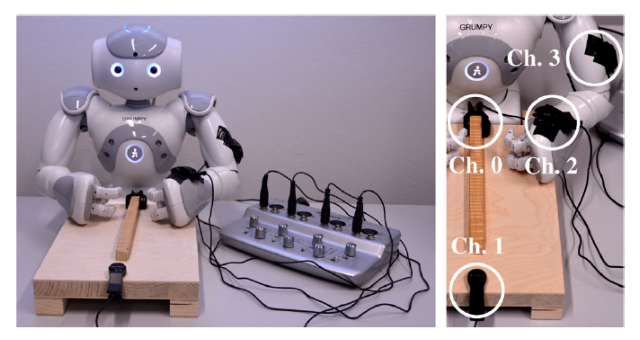

In [395]:
fig, axes = plt.subplots(1,1, figsize=(8,8), dpi=100)
image_path = f'../main/images/setup.png'
img = mpimg.imread(image_path)
axes.imshow(img)
axes.axis('off')
plt.show() 

**Figure 1:** Setup of the experiment used to acquire the acoustic/vibration data including a robotic hand, a serrated wooden stick on which the objects are rubbed and the contact microphones (two on the robot itself and two on the serrated stick) [(Toprak, 2017)](#dataset).

**Solution Approach/Technique**: Different approaches have been used to classify objects and surfaces textures using vibration data acquired in a variety of setups (e.g. mobile robots, robotic hands, scanning probes, grippers). The most common approaches involve:
1. regression algorithms (e.g. SVM, k-NN) [(Wang, 2022)](#regression), [(Hughes, 2014)](#skin);
2. recurrent neural networks [(Jonetzko, 2020)](#pills);
3. transformers (paired with a CNN) [(Chang, 2023)](#transformer).

The authors of the paper from which the dataset is taken use a 'growing when required network' to predict object classes from vibration and achieve a maximum accuracy of $68.2\%$ [(Toprak, 2017)](#dataset). This performance metric will serve as a benchmark for evaluating the performance of the model used in this project.

In this project, we use **Hidden Markov Models (HMMs)** to predict the class of an object based solely on vibration data. Similar to a Markov Model, a HMM is defined by a set of states ($\mathcal{S}$) and transition probabilities (usually represented by a matrix $\mathbf{A}$). What makes HMMs unique is that states are **not** directly observable. Instead, we rely on observations ($\mathcal{O}$) to predict the underlying states in the system. As such, we define emission densities ($\mathbf{b}$) which express the probability distribution over the set of observations for each hidden state [(Jurafsky, 2023)](#tb). To apply HMMs for classification, we generate a model (defined by the set $\{\mathbf{A}, \mathbf{b}\}$) for each class using training data. The predicted class of an unlabelled sequence of observations is the one whose model yields the highest likelihood prediction.

HMMs have been widely applied in speech classification tasks [(Gales, 2007)](#speech). For word classification HMMs, the hidden states of the system are phonemes-which are the basic units of sound that comprise words-and the observations are microphone data of complete utterances [(Sandsmark, 2010)](#tutorial). In this project we can consider the observations/utterances to be the raw microphone data (vibrations) resulting from the movement of the object over the serrated stick. The hidden states of our system are unique, possibly repetitive features that arise in the acoustic data. These features may be time-series peaks, a set of recurrent frequencies or any other pattern that we learn from the time and frequency domain representation of the acoustic data. Given the similarity between speech and vibration data derived from object explorations, we hypothesis that HMMs can be used for classification.

#### References

<a id=biomimetic></a>
O. A. J. Quilachamin, “A Biomimetic Fingerprint for Robotic Tactile Sensing,” arXiv e-prints, no. arXiv-2307, Jul. 2023.

<a id=dataset></a>
S. Toprak, N. Navarro-Guerrero, and S. Wermter, “Evaluating Integration Strategies for Visuo-Haptic Object Recognition,” Cognitive Computation, vol. 10, no. 3, pp. 408–425, Dec. 2017, doi: https://doi.org/10.1007/s12559-017-9536-7.

<a id=transformer></a>
E. Chang, “An Investigation of Multi-feature Extraction and Super-resolution with Fast Microphone Arrays,” arXiv e-prints, no. arXiv:2310.00206, Sep. 2023.

<a id=regression></a>
Si Ao Wang, A. Albini, P. Maiolino, F. Mastrogiovanni, and G. Cannata, “Fabric Classification Using a Finger-Shaped Tactile Sensor via Robotic Sliding,” Frontiers in Neurorobotics, vol. 16, Feb. 2022, doi: https://doi.org/10.3389/fnbot.2022.808222.

<a id=skin></a>
D. Hughes and N. Correll, “A soft, amorphous skin that can sense and localize textures,” May 2014, doi: https://doi.org/10.1109/icra.2014.6907101.

<a id=pills></a>
Y. Jonetzko, “Multimodal object analysis with auditory and tactile sensing using recurrent neural networks,” International Conference on Cognitive Systems and Signal Processing, pp. 253–265, 2020.

<a id=dudek></a>
N. Roy, G. Dudek, and P. L. Freedman, “Surface sensing and classification for efficient mobile robot navigation,” Dec. 2002, doi: https://doi.org/10.1109/robot.1996.506874.

<a id=tb></a>
D. Jurafsky and J. Martin, Speech and Language Processing, 3rd ed. 2023.

<a id=stretch></a>
Jean-Baptiste Chossat and Peter B Shull. Soft acoustic waveguides for strain, deformation, localization, and twist measurements. IEEE Sensors Journal, 21(1):222–230, 2020.

<a id=slip></a>
Cheng Liu, Tae Myung Huh, Spencer X Chen, Lingling Lu, Fotis Kopsaftopoulos, Mark R Cutkosky, and Fu-Kuo Chang. Design of active sensing smart skin for incipient slip detection in robotics applications. IEEE/ASME Transactions on Mechatronics, 2022.

<a id=speech></a>
M. Gales and S. Young. The application of Hidden Markov models in speech recognition. Foundations and Trends® in Signal Processing, 1(3), pp. 195–304, doi:10.1561/2000000004. 

<a id=tutorial></a>
Hakon Sandsmark. Isolated-word speech recognition using hidden Markov models. 2010. https://google-code-archive-downloads.storage.googleapis.com/v2/code.google.com/hmm-speech-recognition/report.pdf

<a id=tactile></a>
R. S. Dahiya, P. Mittendorfer, M. Valle, G. Cheng, and V. J. Lumelsky, “Directions Toward Effective Utilization of Tactile Skin: A Review,” IEEE Sensors Journal, vol. 13, no. 11, pp. 4121–4138, Nov. 2013, doi: https://doi.org/10.1109/JSEN.2013.2279056.

<a id=explore1></a>
Rachel Thomasson, Etienne Roberge, Mark R Cutkosky, and Jean-Philippe Roberge. Going in blind: Object motion classification using distributed tactile sensing for safe reaching in clutter. In 2022 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS), pages 1440–1446. IEEE, 2022.

<a id=explore2></a>
Alessandro Albini, Francesco Grella, Perla Maiolino, and Giorgio Cannata. Exploiting distributed tactile sensors to drive a robot arm through obstacles. IEEE Robotics and Automation Letters, 6(3):4361–4368, 2021.

### Objects in Dataset
First, we show the objects in the dataset. Visually we recognize that some of these objects have a similar texture and so classification using contact microphone data may not always work. 

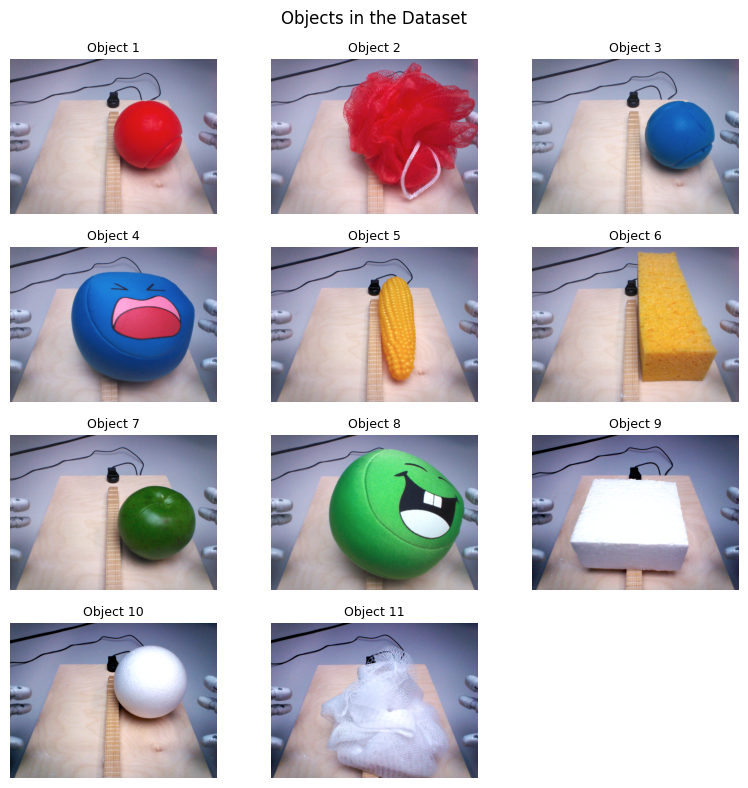

In [89]:
#plot the objects in the dataset
num_rows = 4
num_cols = 3
total_images = num_rows * num_cols
objects = 11

#create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8,8))  # Adjust figsize accordingly
fig.suptitle('Objects in the Dataset')

#initialize a counter for the image index
idx = 0

#iterate through the subdirectories
for object_num in range(1, objects + 1):
    run_ideal_num = 0
    run_ideal_num += 10 * (object_num - 1)
    image_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/foreground.png'
    img = mpimg.imread(image_path)
    i, j = divmod(idx, num_cols)
    axes[i, j].imshow(img)
    axes[i, j].set_title(f'Object {object_num}', fontsize=9)
    axes[i, j].axis('off')
    idx += 1

fig.delaxes(axes[-1, -1])
plt.tight_layout()
plt.show()

### Initial Analysis of Data
Our dataset compromises microphone vibration data resulting from the rubbing motion of different objects on a serrated wooden stick. The dataset contains vibration data from four microphones. We will only use the data from '**Ch. 0**' which corresponds to data from the microphone attached to the wooden stick (see **Fig. 1**) [(Toprak, 2017)](#dataset). '**Ch. 0**' was selected since it yielded the highest classification accuracy in a study using the same dataset [(Toprak, 2017)](#dataset). There are 11 objects in the dataset and 13 observations per object [(Toprak, 2017)](#dataset). Ten observations are acquired in what the authors of the dataset call 'ideal' conditions and three in 'real conditions'. According to the authors, under 'real' conditions, "*We let the robot perform some of the object exploration runs in a slightly imprecise manner*" [(Toprak, 2017)](#dataset).

To be able to classify objects we require there to be differences in either the time or frequency-domain representations of the vibration data. We therefore start by analyzing the data to see if there are differences in the vibration data for each object. To do this we compare the raw audio (time-domain), Mel spectrograms and the Mel frequency cepstral coefficients (MFCCs) for the audio acquired for a given experiment for each object. MFCC components are often used as a frequency-domain representation of audio data in speech and other audio recognition tasks [(Jonetzko, 2020)](#pills), [(Maxime, 2014)](#robots). MFCC components are useful in audio recognition tasks since they provide a good representation of the spectral envelope of a signal while removing finer spectral structure [(Aalto University Wiki)](#wiki.aalto).

#### References

<a id="wiki.aalto"></a>
“Cepstrum and MFCC - Introduction to Speech Processing - Aalto University Wiki,” wiki.aalto.fi. https://wiki.aalto.fi/display/ITSP/Cepstrum+and+MFCC

<a id=pills></a>
Y. Jonetzko, “Multimodal object analysis with auditory and tactile sensing using recurrent neural networks,” International Conference on Cognitive Systems and Signal Processing, pp. 253–265, 2020.

<a id=robots></a>
J. Maxime, X. Alameda-Pineda, L. Girin, and R. Horaud, “Sound representation and classification benchmark for domestic robots,” IEEE Xplore, May 01, 2014. https://ieeexplore.ieee.org/abstract/document/6907786/.

<a id=dataset></a>
S. Toprak, N. Navarro-Guerrero, and S. Wermter, “Evaluating Integration Strategies for Visuo-Haptic Object Recognition,” Cognitive Computation, vol. 10, no. 3, pp. 408–425, Dec. 2017, doi: https://doi.org/10.1007/s12559-017-9536-7.

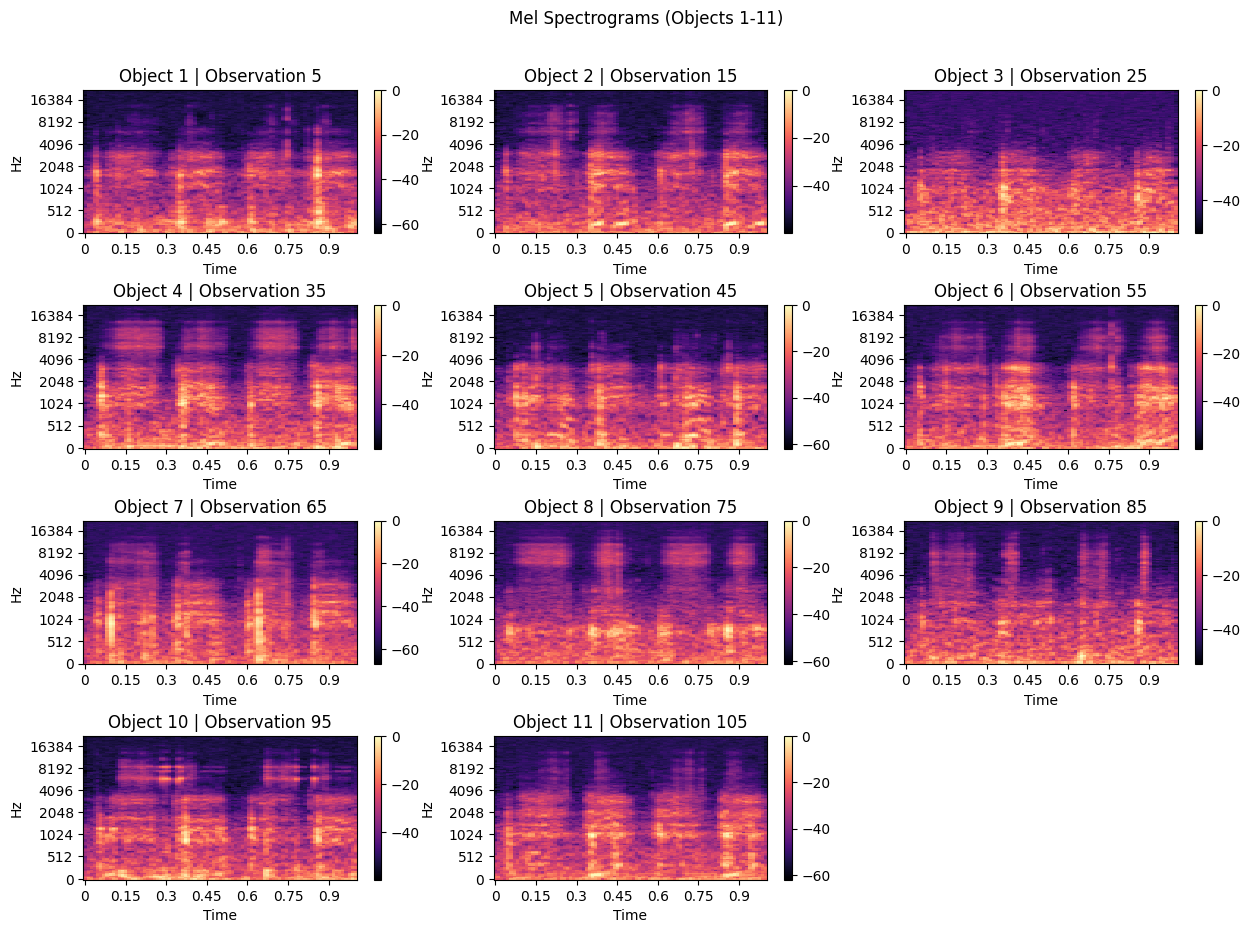

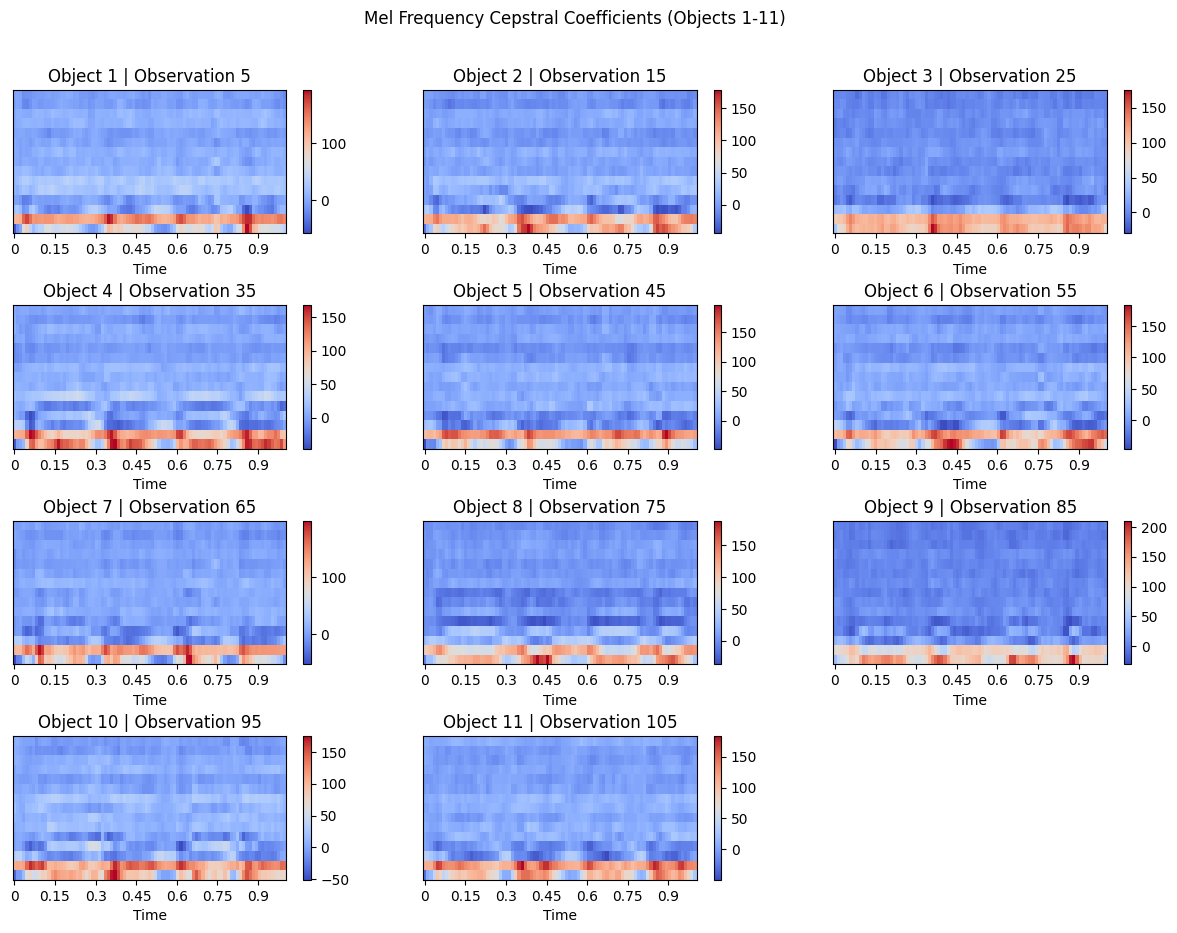

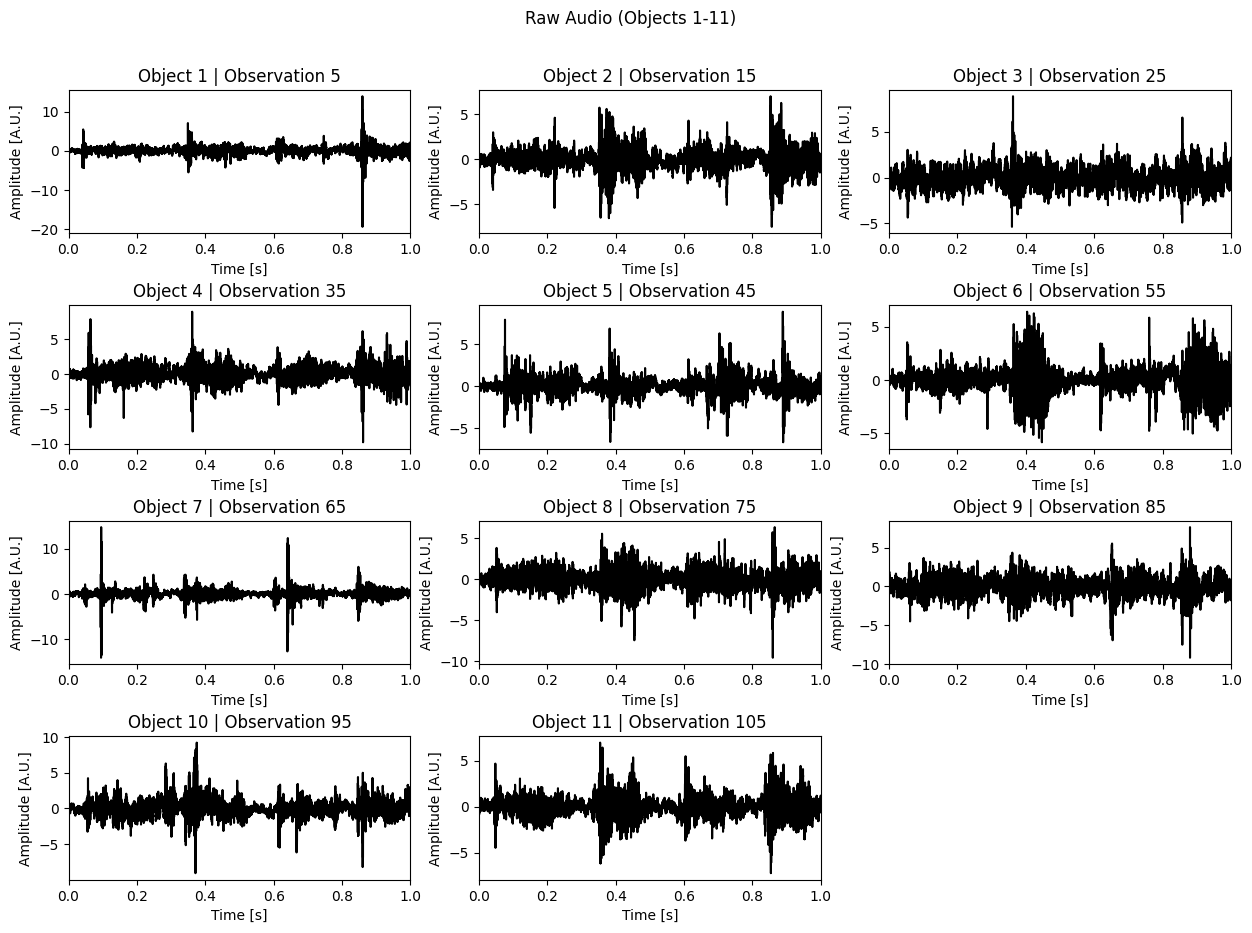

In [101]:
#extract the raw signal, MFCC components and Mel spectrograms for each object
#dataset source: https://figshare.com/articles/dataset/Supplementary_Material_for_Evaluating_Integration_Strategies_for_Visuo-Haptic_Object_Recognition_/5280949
channel = 0            #channel to read data from
objects = 11           #total number of objects in the dataset

num_rows = 4
num_cols = 3

fig_1, axes_1 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))
fig_2, axes_2 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))
fig_3, axes_3 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

fig_1.suptitle('Mel Spectrograms (Objects 1-11)')
fig_2.suptitle('Mel Frequency Cepstral Coefficients (Objects 1-11)')
fig_3.suptitle('Raw Audio (Objects 1-11)')

for object_num in range(1, min(objects, num_rows * num_cols) + 1):
    run_ideal_num = 5  #only plot the data from the first run
    run_ideal_num += 10 * (object_num - 1)
    file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/haptic_texture/clean_signal.wav'
    sampling_freq, audio = audio_extraction(file_path, channel, scaling=True)

    mfcc_features = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=15)
    S = librosa.feature.melspectrogram(y=audio, sr=sampling_freq, n_mels=128)

    #calculate the row and column indices for the subplot
    row = (object_num - 1) // num_cols
    col = (object_num - 1) % num_cols

    #plot Mel spectrogram
    img1 = librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sampling_freq, x_axis='time', y_axis='mel', ax=axes_1[row, col])
    fig_1.colorbar(img1, ax=axes_1[row, col])
    axes_1[row, col].set_title(f'Object {object_num} | Observation {run_ideal_num}')

    #plot the MFCC
    img2 = librosa.display.specshow(mfcc_features, sr=sampling_freq, x_axis='time', ax=axes_2[row, col])
    fig_2.colorbar(img2, ax=axes_2[row, col])
    axes_2[row, col].set_title(f'Object {object_num} | Observation {run_ideal_num}')

    #plot the raw audio
    time = np.arange(len(audio)) / sampling_freq
    axes_3[row, col].plot(time, audio, '-k')
    axes_3[row, col].set_xlabel('Time [s]')
    axes_3[row, col].set_ylabel('Amplitude [A.U.]')
    axes_3[row, col].set_title(f'Object {object_num} | Observation {run_ideal_num}')
    axes_3[row, col].set_xlim([0,1])

#remove the empty subplot
fig_1.delaxes(axes_1[-1, -1])
fig_2.delaxes(axes_2[-1, -1])
fig_3.delaxes(axes_3[-1, -1])

# Adjust layout to prevent overlapping
fig_1.subplots_adjust(hspace=0.5, top=0.9)
fig_2.subplots_adjust(hspace=0.5, top=0.9)
fig_3.subplots_adjust(hspace=0.5, top=0.9)

Upon examination of the above plots we see that there are clear visual differences in the raw data, the MFCC features and the spectrograms for each object. In particular, the MFCC features and spectrograms appear to contain repeating elements which indicates that there are underlying hidden states that can be learned from the data. Repetitive features are not so easily identifiable in the raw vibration data. We will proceed with the use of the MFCC features to represent the frequency domain of the vibration data.

### Data Processing
Several processing steps are usually performed on time-series data. These include:
- De-noising* (e.g. using spectral noise subtraction) [(Toprak, 2017)](#dataset), [(Hughes, 2014)](#skin)
- Data normalization to zero mean ($\mu = 0$) and unit standard deviation ($\sigma = 1$) [(Wang, 2022)](#regression)

*I will make use of the de-noised versions of each time-series which are included in the dataset.

We also split the dataset into training and testing data. We use a $0.70~\text{train}/0.30~\text{test}$ split for for the both real and ideal observations which split used in the paper in which the dataset was originally presented [(Toprak, 2017)](#dataset). The selected train/test split results in 99 observation for training and 44 observation for testing.

#### References
<a id=regression></a>
Si Ao Wang, A. Albini, P. Maiolino, F. Mastrogiovanni, and G. Cannata, “Fabric Classification Using a Finger-Shaped Tactile Sensor via Robotic Sliding,” Frontiers in Neurorobotics, vol. 16, Feb. 2022, doi: https://doi.org/10.3389/fnbot.2022.808222.

<a id=dataset></a>
S. Toprak, N. Navarro-Guerrero, and S. Wermter, “Evaluating Integration Strategies for Visuo-Haptic Object Recognition,” Cognitive Computation, vol. 10, no. 3, pp. 408–425, Dec. 2017, doi: https://doi.org/10.1007/s12559-017-9536-7.

<a id=skin></a>
D. Hughes and N. Correll, “A soft, amorphous skin that can sense and localize textures,” May 2014, doi: https://doi.org/10.1109/icra.2014.6907101.

In [3]:
def audio_normalization(y: np.array):
    #scale audio data to zero mean and unit standard deviation
    ys = np.zeros(y.shape)
    m = np.mean(y)
    std = np.std(y)
    ys = (y - m) / std

    return ys

In [4]:
def audio_extraction(file_path, channel, scaling=False):
    #convert .wav file to array of amplitudes
    sampling_freq, audio = wavfile.read(file_path)
    audio = np.array(audio[:, channel])
    audio = audio.astype(np.float64)

    if scaling == True:
        audio = audio_normalization(audio)

    return sampling_freq, audio

In [5]:
def mfcc_compute(default_config, sampling_freq, audio, mfcc_features, window_factor=None, padding_factor=None, hop_factor=None):
    #compute the MFCC components of the input signal
    if default_config == False:
        samples_per_run = 44100
        window_size_s = round(samples_per_run*window_factor)
        n_fft = window_size_s*padding_factor
        hop_length_s = round(window_size_s*hop_factor)
        mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features, n_fft=n_fft, hop_length=hop_length_s, win_length=window_size_s)
    elif default_config == True:
        mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features)

    return mfcc_output

In [6]:
def data_extraction(channel, mfcc_features, scaling=True, window_factor=None, padding_factor=None, hop_factor=None, default_config=False):
    #function to extract training/testing data
    #dataset source: https://figshare.com/articles/dataset/Supplementary_Material_for_Evaluating_Integration_Strategies_for_Visuo-Haptic_Object_Recognition_/5280949
    
    #fixed parameters
    objects =        11                  #number of objects in dataset
    obs_ideal =      10                  #total number of ideal runs
    obs_real =       3                   #total number of real runs

    #initialize arrays
    data = {}
    lengths = {}
    
    for object_num in range(1, objects + 1):
        idx = 1
        obs_start = obs_ideal*(object_num - 1)
        for obs in range(obs_start, obs_ideal + obs_start):
            file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{obs}/haptic_texture/clean_signal.wav'
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = mfcc_compute(default_config=default_config,
                                       sampling_freq=sampling_freq, 
                                       audio=audio, 
                                       mfcc_features=mfcc_features,
                                       window_factor=window_factor, 
                                       padding_factor=padding_factor, 
                                       hop_factor=hop_factor)
            
            data[(object_num, idx)] = np.transpose(mfcc_output)
            lengths[(object_num, idx)] = np.transpose(mfcc_output).shape[0]
            idx += 1
            
        obs_start = obs_real*(object_num - 1)
        for obs in range(obs_start, obs_real + obs_start):
            file_path = f'../Toprak_Dataset/raw-data/real/object_{object_num}/observation_{obs}/haptic_texture/clean_signal.wav'
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = mfcc_compute(default_config=default_config,
                                       sampling_freq=sampling_freq, 
                                       audio=audio, 
                                       mfcc_features=mfcc_features,
                                       window_factor=window_factor, 
                                       padding_factor=padding_factor, 
                                       hop_factor=hop_factor)
            
            data[(object_num, idx)] = np.transpose(mfcc_output)
            lengths[(object_num, idx)] = np.transpose(mfcc_output).shape[0]
            idx += 1   
    return data, lengths

### Creating the Hidden Markov Model
There are three key processes used to train and evaluate a HMM [(Jurafsky, 2023)](#tb):
1. Likelihood estimation: given an HMM with parameters $\lambda = \{\mathbf{A}, \mathbf{b}\}$ and an observation sequence $\mathcal{O}$, determine the likelihood $P(\mathcal{O}|\lambda)$. We solve this using what is known as the **forward algorithm**;
2. Hidden state decoding: given an observation sequence ($\mathcal{O}$) and an HMM with parameters $\lambda = \{\mathbf{A}, \mathbf{b}\}$, determine the best hidden state sequence ($\mathcal{S}$). We solve this using the **Viterbi algorithm**;
3. Learning model parameters: given an observation sequence ($\mathcal{O}$) and the set of possible states in the HMM ($s \in \mathcal{S}$), determine the HMM parameters $\lambda = \{\mathbf{A}, \mathbf{b}\}$. We solve this using the **forward-backward algorithm**.

We leverage the $\texttt{hmmlearn}$ ([source code](https://github.com/hmmlearn/hmmlearn)) library to create a HMM. $\texttt{hmmlearn}$ has three main functions: 
- $\texttt{fit}(~)$: used to train the HMM
- $\texttt{predict}(~)$: used to predict the sequence of hidden states for a given sequence (not used here)
- $\texttt{score}(~)$: used to evaluate the likelihood of a given observation given the model. 

The structure of an HMM is shown in **Fig. 2**. A HMM is trained for every object in the dataset yielding 11 models, $\lambda_k \in \boldsymbol{\lambda} \left(k \in [1,2,\dots,11] \right)$ where each model is defined by a transition matrix and emission probabilities, $\lambda_k = \{\mathbf{A}_k, \mathbf{b}_k\}$. Each model is trained on a concatenated array of observation sequences for the given object. We pre-select the maximum possible number of hidden states and assume that this number is the same for all object models. To make a prediction we feed a test observation sequence, $\mathcal{O}_{\text{test}}$ through each model and extract the predictions, $P(\mathcal{O}_{\text{test}}|\lambda_k)$. The predicted class, $c_{\text{test}} \in \{\text{Object}~1,\text{Object}~2,\dots,\text{Object}~11\}$ of the object is determined as, $\max P(\mathcal{O}_{\text{test}}|\lambda_k), k \in [1,2,\dots,11]$.

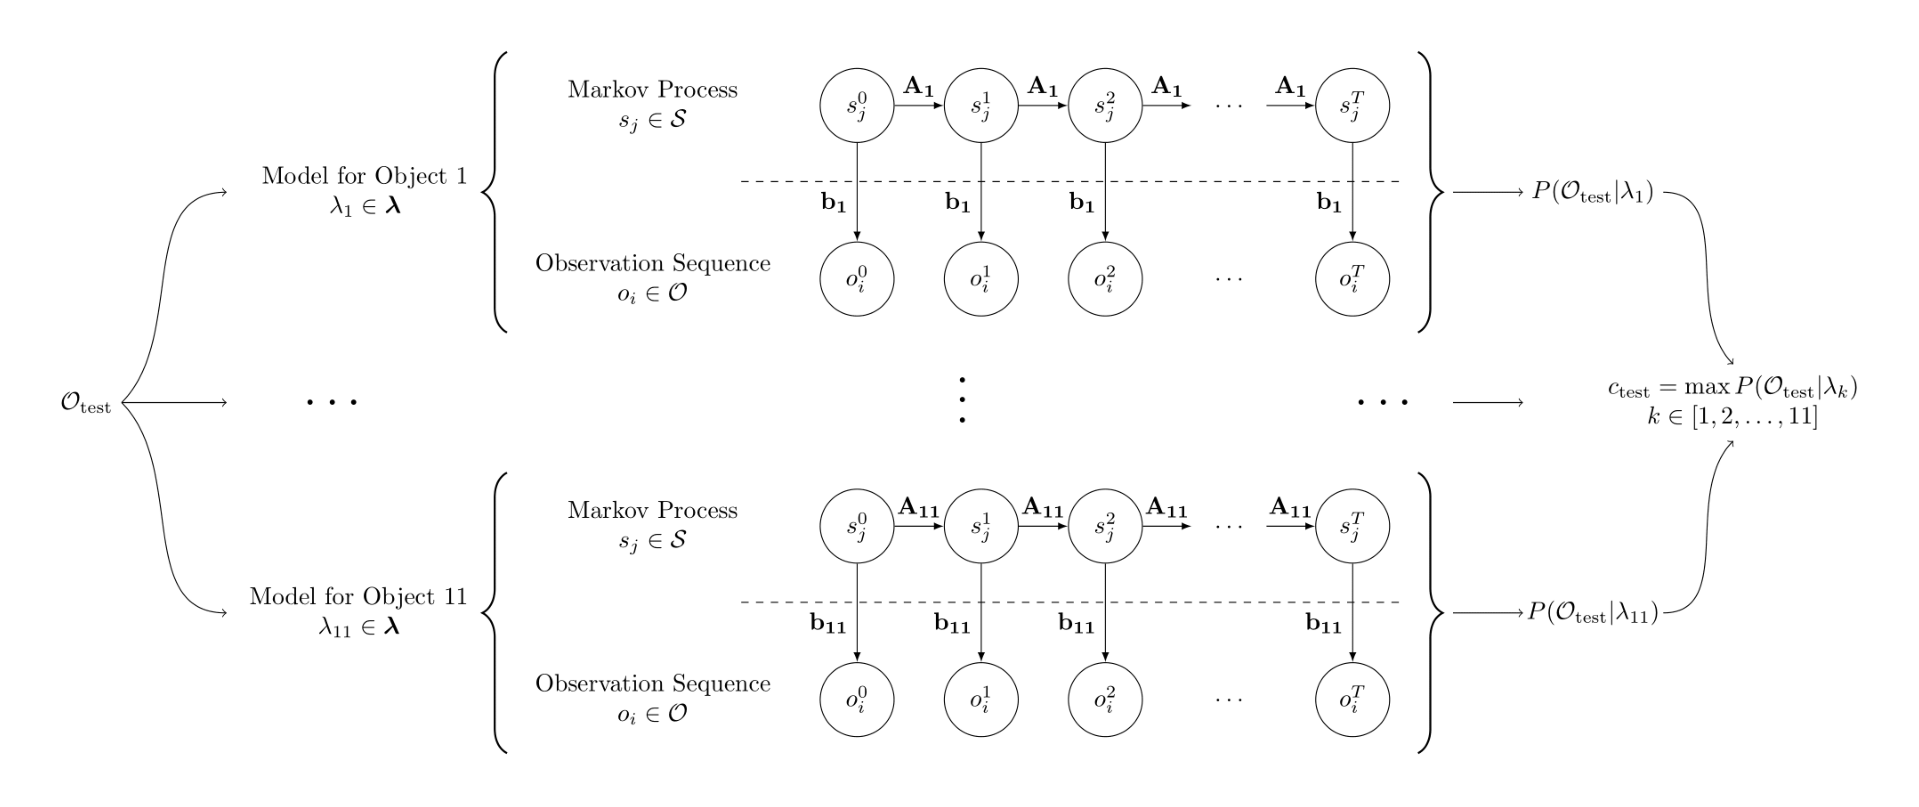

In [391]:
fig, axes = plt.subplots(1,1, figsize=(8,8), dpi=300)
image_path = f'../tikz_figures/hmm_3.png'
img = mpimg.imread(image_path)
axes.imshow(img)
axes.axis('off')
plt.show()

**Figure 2**: Illustration of the Hidden Markov Model-based algorithm used for classification.

#### References
<a id=tb></a>
D. Jurafsky and J. Martin, Speech and Language Processing, 3rd ed. 2023.

In [7]:
class hmm_generation(object):
  def __init__(self, model_name='GaussianHMM', hidden_states=4, cov_type='diag', start_state=None, n_iter=1000):
    #model structure adapted from (1) https://blog.goodaudience.com/music-genre-classification-using-hidden-markov-models-4a7f14eb0fd4 
    #                             (2) https://maharshi-yeluri.medium.com/understanding-and-implementing-speech-recognition-using-hmm-6a4e7666de1 
    self.model_name = model_name
    self.n_components = hidden_states
    self.cov_type = cov_type
    self.n_iter = n_iter
    self.start_state = start_state
    #initialize the HMM
    if self.model_name == 'GaussianHMM':
      self.model = hmm.GaussianHMM(n_components=self.n_components, random_state=self.start_state, covariance_type=self.cov_type, n_iter=self.n_iter)
    elif self.model_name == 'GMMHMM':
      self.model = hmm.GMMHMM(n_components=self.n_components, random_state=self.start_state, covariance_type=self.cov_type, n_iter=self.n_iter)
    elif self.model_name == 'MultinomialHMM':
      self.model = hmm.MultinomialHMM(n_components=self.n_components, random_state=self.start_state, n_iter=self.n_iter)
    elif self.model_name == 'PoissonHMM':
      self.model = hmm.PoissonHMM(n_components=self.n_components, random_state=self.start_state, n_iter=self.n_iter)
    else:
      raise TypeError('Invalid model type') 

  def train(self, training_data, lengths):
    #train the model using the fit() function from hmmlearn
    np.seterr(all='ignore')
    self.model.fit(training_data, lengths)
    return self.model.monitor_.converged

  def observation_likelihood(self, observation_sequence, lengths=None):
    #compute observation likelihood using the score() function from hmmlearn
    return self.model.score(observation_sequence, lengths=lengths)

  def transition_matrix(self):
    #extract the transition probability matrix
    return self.model.transmat_

In [8]:
def random_selection(split):
    # randomly select the train/test observations based on the train/test split
    total_obs = 13
    train_obs = round(total_obs * split)
    
    # Elements from real_obs
    real_obs_set = [11, 12, 13]
    ideal_obs_set = [i for i in range(1, 11)]
    
    #shuffle the real and ideal observations
    random.shuffle(real_obs_set)
    random.shuffle(ideal_obs_set)

    train_nums = real_obs_set[:2] + ideal_obs_set[0:train_obs-2]
    test_nums = real_obs_set[2:] + ideal_obs_set[train_obs-2:]

    return train_nums, test_nums

In [9]:
def split_data(data, lengths, split):
    #function to split data AND ensure that there is at least one real observation in the training and testing data
    #fixed parameters
    objects = 11

    real_obs = [11,12,13]
    test_nums = []
    train_nums = []

    train_nums, test_nums = random_selection(split=split)
    print(train_nums)
    print(test_nums)

    train_data = {}
    test_data = {}
    #-----------------
    train_lengths = {}
    test_lengths = {}

    for object_num in range(1, objects + 1):
        train_data[object_num] = []
        train_lengths[object_num] = []
        test_data[object_num] = []
        test_lengths[object_num] = []
        for obs in train_nums:
            train_data[object_num].append(data[(object_num, obs)])
            train_lengths[object_num].append(lengths[(object_num, obs)])
        for obs in test_nums:
            test_data[object_num].append(data[(object_num, obs)])
            test_lengths[object_num].append(lengths[(object_num, obs)])

    return train_data, test_data, train_lengths, test_lengths

def concatenate_data(data):
    #fixed parameters
    objects = 11
    
    data_concatenate = {}
    for object_num in range(1, objects + 1):
        data_concatenate[object_num] = []
        for obs_sequence in data[object_num]:
            for value in obs_sequence:
                data_concatenate[object_num].append(value)
    
    return data_concatenate
        


In [10]:
def model_training(hidden_states, model_name, cov_type, start_state, train_data, train_lengths):
    #train the model using the training dataset
    objects = 11

    trained_models = {}
    trained_model = None
    conv_bool_set = []
    transition_matrices = {}

    #train a HMM for each object in the dataset
    for object_num in range(1, objects + 1):
        trained_model = hmm_generation(model_name=model_name, hidden_states=hidden_states, cov_type=cov_type, start_state=start_state)
        conv_bool = trained_model.train(training_data=train_data[object_num], lengths=train_lengths[object_num])
        if conv_bool == True:
            conv_bool_set.append('True')
        else:
            conv_bool_set.append('False')
        
        transition_matrices[object_num] = trained_model.transition_matrix()
        trained_models[object_num] = trained_model
        trained_model = None
        
    
    return trained_models, conv_bool_set, transition_matrices

In [11]:
def model_testing(trained_models, data):
    #estimate the label of each time-series in the testing dataset
    #fixed parameters
    objects = 11
    
    #initialize arrays
    predicted_labels = []
    real_labels = []

    #iterate over all objects
    for object_num in range(1, objects + 1):
        #iterate over all observation sequences for each object
        for obs_sequence in data[object_num]:
            #predict the likelihood that an observation sequence comes from the models corresponding to each object
            for object_num_sub in range(1, objects + 1):
                trained_model = trained_models[object_num_sub]
                curr_score = trained_model.observation_likelihood(obs_sequence)
                #keep track of the model which yields in the highest likelihood
                if object_num_sub == 1:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
                elif curr_score > highest_score:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
            #store the prediction
            real_labels.append(f'Obj. {object_num}')
            predicted_labels.append(f'Obj. {highest_likelihood_object}')
    
    return real_labels, predicted_labels

In [12]:
def model_accuracy(real_labels, predicted_labels):
    #compute the accuracy of a set of predictions
    accuracy = accuracy_score(real_labels, predicted_labels)
    
    return accuracy

In [13]:
def print_convergence(conv_bool_set):
    #output whether the HMM converged or not during training
    for idx, value in enumerate(conv_bool_set):
        print(f'Object {idx + 1: <2}: {value: <2}| ', end="")
    print('\n')

In [14]:
def plot_confusion_matrix(ax, cm, classes, title, normalize=False):
    #function to generate confusion matrices
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cmap = plt.cm.Reds

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

### Overview of Experiments + Discussion
We will now perform a series of experiments aimed at understanding the behavior of the HMM and to determine an 'optimal' set of parameters. Each experiment will include a brief analysis and discussion of the results.

In [21]:
#define data extraction parameters
channel = 0
scaling = True
mfcc_features = 15
default_config = True 

#define train/test split
total_obs = 13
split = 0.7

#extract data
data, lengths = data_extraction(channel=channel,
                                mfcc_features=mfcc_features, 
                                default_config=default_config,                                                        
                                scaling=scaling) 

train_data, test_data, train_lengths, test_lengths = split_data(data, lengths, split)
train_data_concatenated = concatenate_data(train_data)    

[12, 13, 4, 10, 9, 3, 7, 8, 6]
[11, 1, 2, 5]


### Varying the Number of Hidden States
In the first experiment we will analyze the effect of changing the number of possible hidden states in the HMM. We will do this by creating a training/testing dataset and then by evaluating the accuracy of HMMs with different numbers of allowable hidden states.

In [22]:
%%capture
#analyze the effect of changing the number of hidden states
#model parameters
model_name = 'GaussianHMM'
cov_type = 'diag'
start_state = 1
hidden_states_max = round(total_obs*split)
hidden_states_set = [i for i in range(1,hidden_states_max+1)]

#initialize arrays
accuracies_train = []
real_labels_all_train = {}
predicted_labels_all_train = {}
#------------------------------
accuracies_test = []
real_labels_all_test = {}
predicted_labels_all_test = {}
#------------------------------
transition_matrices_all = {}                                                        

#train and test the model for different numbers of hidden states
for hidden_states in hidden_states_set:
    #train a model for each object
    trained_models, conv_bool_set, transition_matrices = model_training(hidden_states=hidden_states,
                                                                        model_name=model_name,
                                                                        cov_type=cov_type,
                                                                        start_state=start_state,
                                                                        train_data=train_data_concatenated,
                                                                        train_lengths=train_lengths)

    transition_matrices_all[hidden_states] = transition_matrices                                       
    #test the models
    real_labels_train, predicted_labels_train = model_testing(trained_models=trained_models,
                                                              data=train_data)
    
    real_labels_test, predicted_labels_test = model_testing(trained_models=trained_models,
                                                            data=test_data)
    
    print(f'Number of Hidden States: {hidden_states}')
    print_convergence(conv_bool_set)
    
    #store the predicted and real labels
    accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
    accuracies_test.append(accuracy_test)
    real_labels_all_test[hidden_states] = real_labels_test
    predicted_labels_all_test[hidden_states] = predicted_labels_test

    accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
    accuracies_train.append(accuracy_train)
    real_labels_all_train[hidden_states] = real_labels_train
    predicted_labels_all_train[hidden_states] = predicted_labels_train

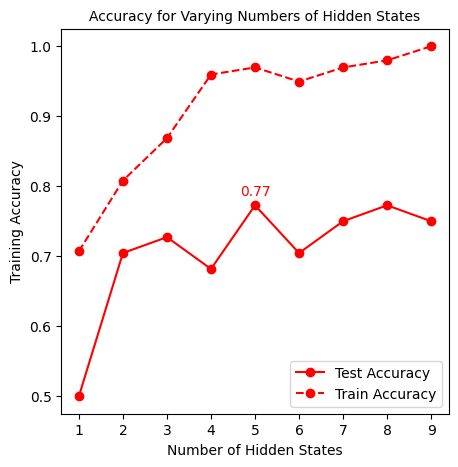

In [23]:
#plot the accuracies for different numbers of hidden states
fig, axes = plt.subplots(1, 1, figsize=(5,5))
axes.set_title("Accuracy for Varying Numbers of Hidden States", fontsize=10)
axes.plot(hidden_states_set, accuracies_test, "-o", color='red', label='Test Accuracy')
axes.plot(hidden_states_set, accuracies_train, "--o", color='red', label='Train Accuracy')
max_test = max(accuracies_test)
max_idx_test = accuracies_test.index(max_test)
axes.annotate(f'{max_test:.2f}', xy=(hidden_states_set[max_idx_test], max_test),
              xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', color='red')

axes.set_xticks(hidden_states_set)
axes.set_xlabel("Number of Hidden States")
axes.set_ylabel("Training Accuracy")
axes.legend(loc='lower right')
plt.show()

The previous cells show the accuracy of the classification tasks for different values of the number of hidden states. The training accuracy tends to increases as the number of hidden states increases. The lowest testing accuracy is observed for one hidden state. A HMM with a single hidden state corresponds to a transition matrix with a single element ($\mathbf{A} = 1$) and emission densities capturing the probability of a given observation. In the remaining experiments we will **not** fix the number of hidden states, since it is likely that the 'optimal' number of hidden states will depend on other parameters in the HMM. Next, we plot the confusion matrices for the testing data.

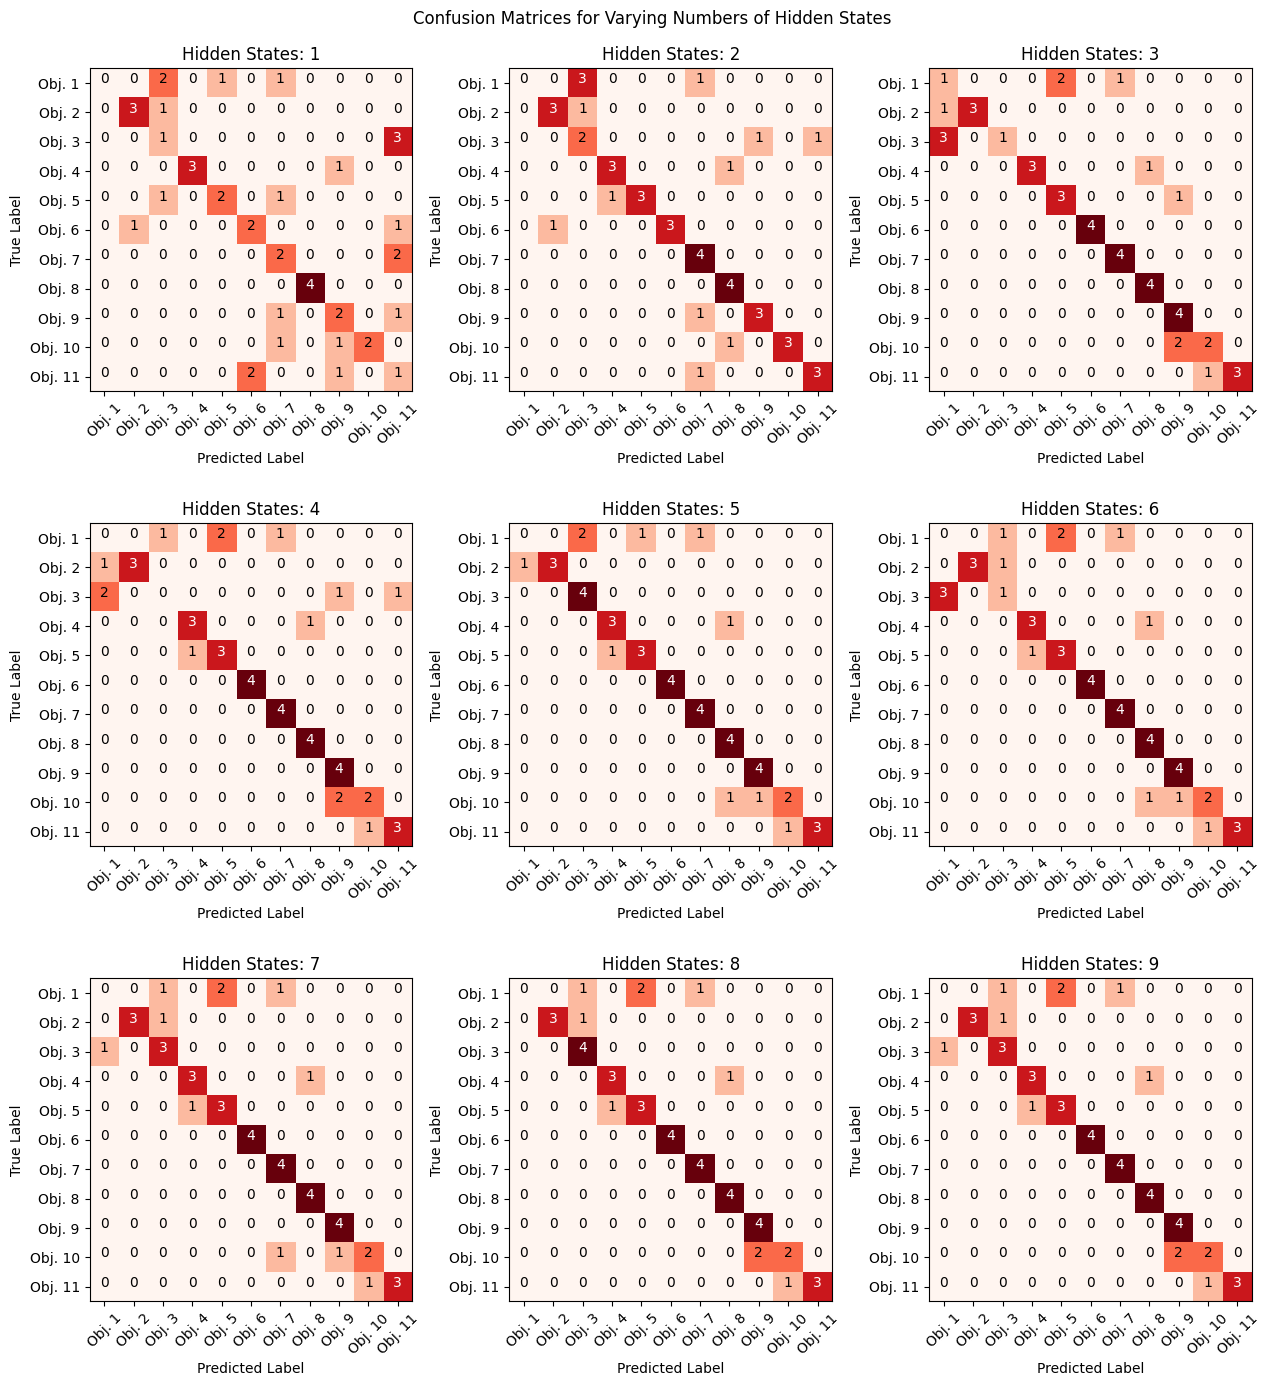

In [24]:
#generate confusion matrices
objects = 11
object_set = [i for i in range(1, objects + 1)]
classes = [f'Obj. {i}' for i in object_set]

num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))
fig.suptitle('Confusion Matrices for Varying Numbers of Hidden States')
fig.subplots_adjust(hspace=0.3, top=0.95, wspace=0.3)

for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    cm = confusion_matrix(real_labels_all_test[hidden_states], predicted_labels_all_test[hidden_states],labels=classes)
    title = f'Hidden States: {hidden_states}'
    plot_confusion_matrix(axes[row_idx, col_idx], cm, classes, title=title, normalize=False)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

plt.show()

Analyzing the confusion matrices above, we note the the high number of misclassifications for object 1, object 4 and object 10. This is somewhat expected since object 1 is sometimes confused for object 3 which is identical except in color, object 4 is confused for object 8 which appears to be identical except in color, and object 10 is confused for object 9 which is identical expect in shape. Next we plot the transition probability matrices.

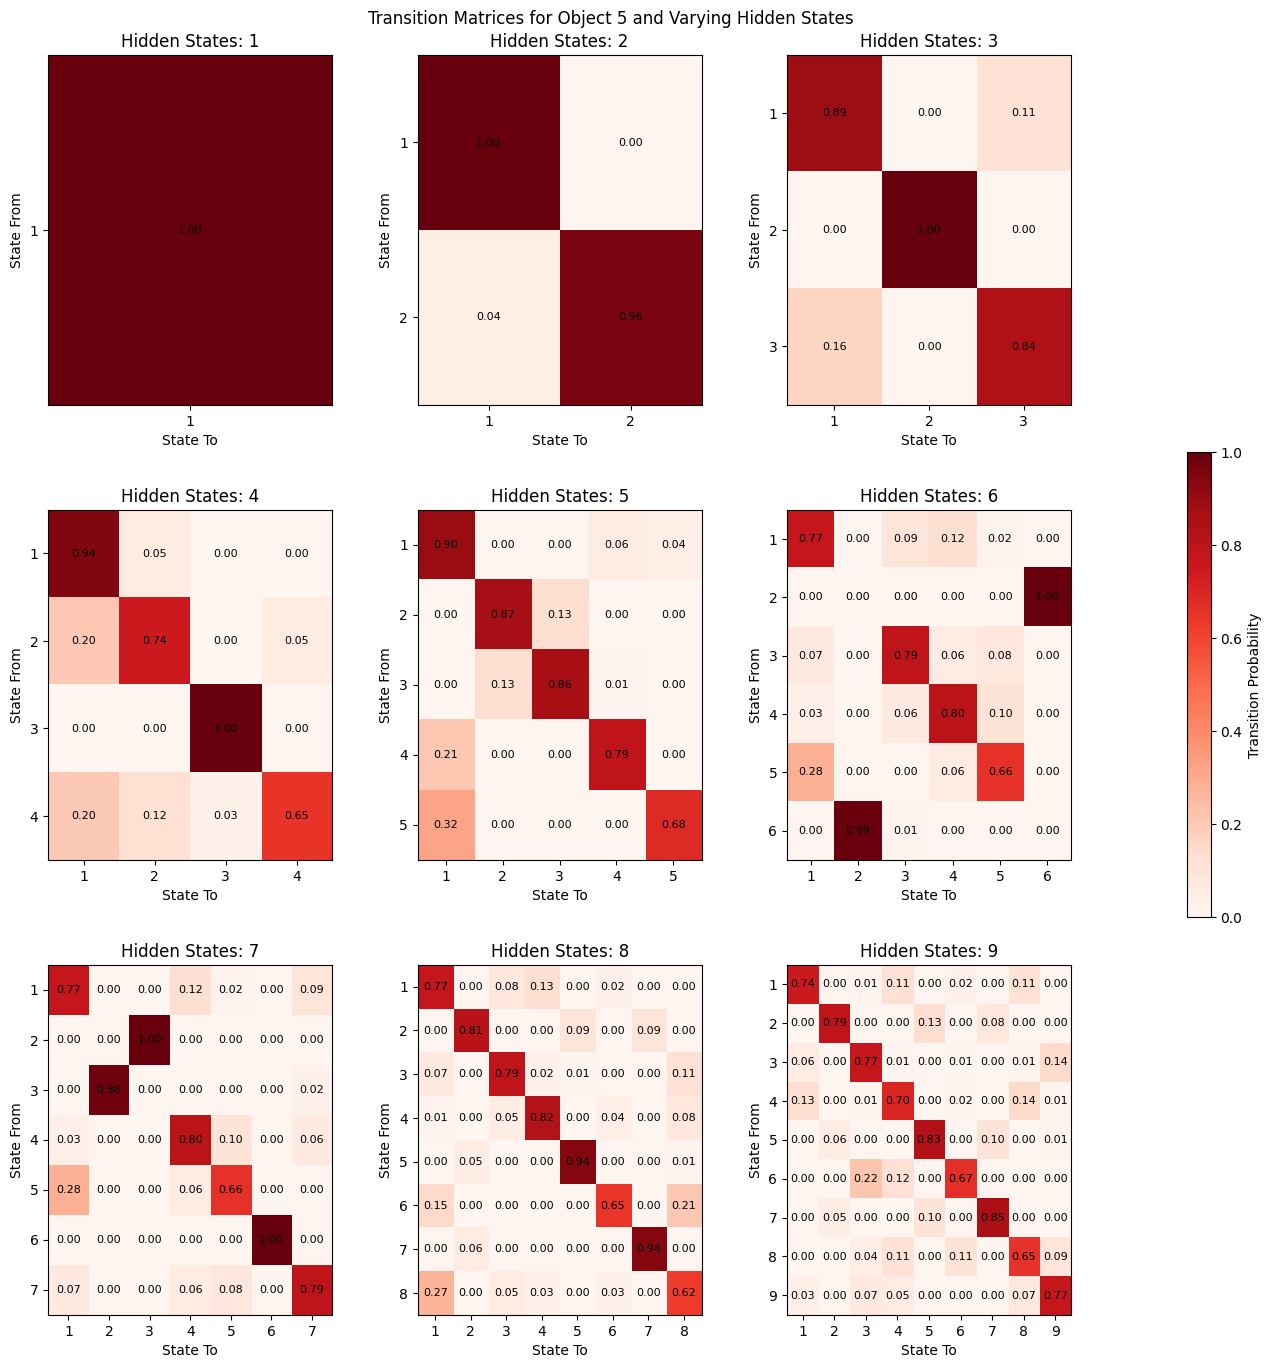

In [25]:
#plot the transition matrices for different hidden states values
#choose object 8 which is classified perfectly for all hidden states
object_to_plot = 5
num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))

cbar_min = min(np.min(matrix) for matrices in transition_matrices_all.values() for matrix in matrices.values())
cbar_max = max(np.max(matrix) for matrices in transition_matrices_all.values() for matrix in matrices.values())

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))
fig.suptitle(f'Transition Matrices for Object {object_to_plot} and Varying Hidden States')
fig.subplots_adjust(hspace=0.3, top=0.95, wspace=0.3)

for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    matrix = transition_matrices_all[hidden_states][object_to_plot]
    im = axes[row_idx, col_idx].imshow(matrix, aspect='auto', cmap='Reds', vmin=cbar_min, vmax=cbar_max)
    axes[row_idx, col_idx].set_title(f'Hidden States: {hidden_states}')
    axes[row_idx, col_idx].set_xlabel('State To')
    axes[row_idx, col_idx].set_ylabel('State From')

    # Set ticks in the middle of the boxes
    axes[row_idx, col_idx].set_xticks(np.arange(len(matrix)))
    axes[row_idx, col_idx].set_yticks(np.arange(len(matrix)))

    # Set tick labels
    axes[row_idx, col_idx].set_xticklabels(np.arange(1, len(matrix) + 1))
    axes[row_idx, col_idx].set_yticklabels(np.arange(1, len(matrix) + 1))

    # Add cell values
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            axes[row_idx, col_idx].text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

# Add a common colorbar
cbar = fig.colorbar(im, ax=axes.ravel(), orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label('Transition Probability') 

# Show the plots
plt.show()

The plots above show the transition probability matrices for different numbers of hidden states and for object five. It is interesting to see that the off-diagonal terms are more pronounced for certain numbers of hidden states. Higher off-diagonal terms indicate that the model is likely capturing transitions between states rather than maintaining the current state.

### Effect of Starting Seed on Model Accuracy
As mentioned [here](https://stackoverflow.com/questions/39930895/why-i-get-different-values-everytime-i-run-the-function-hmmlearn-hmm-gaussianhmm), the expectation-maximization algorithm used by $\texttt{hmmlearn}$ may get trapped in local maxima. Therefore, we expect different model training runs to result in different predictions. Furthermore, the transition probabilities and emission densities predicted in training may depend on the starting seed which may affect the initialization of the model parameters. In the next cells, we will show the effect of changing the starting seed on the training/testing accuracy. Note that we will be using the same training and testing data as the last set of experiments for consistency.

In [26]:
%%capture
#analyze the effect of changing the starting seed
#model parameters
model_name = 'GaussianHMM'
cov_type = 'diag'
start_state_set = [i for i in range(0, 30)]
hidden_states_max = round(total_obs*split)
hidden_states_set = [i for i in range(1,hidden_states_max+1)]

#initialize arrays
accuracies_train = {}
real_labels_all_train = {}
predicted_labels_all_train = {}
#------------------------------
accuracies_test = {}
real_labels_all_test = {}
predicted_labels_all_test = {}

#iterate over different starting seeds
for start_state in start_state_set:
    print(f'Starting Seed: {start_state}')
    accuracies_test[start_state] = []
    accuracies_train[start_state] = []
    #iterate over different numbers of hidden states
    for hidden_states in hidden_states_set:
        trained_models, conv_bool_set, _ = model_training(hidden_states=hidden_states,
                                                          model_name=model_name,
                                                          cov_type=cov_type,
                                                          start_state=start_state,
                                                          train_data=train_data_concatenated,
                                                          train_lengths=train_lengths)
    
        real_labels_train, predicted_labels_train = model_testing(trained_models=trained_models,
                                                                  data=train_data)
    
        real_labels_test, predicted_labels_test = model_testing(trained_models=trained_models,
                                                                data=test_data)
        
        print(f'Number of Hidden States: {hidden_states}')
        print_convergence(conv_bool_set)
        
        #store the labels
        accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
        accuracies_test[start_state].append(accuracy_test)
        real_labels_all_test[(start_state, hidden_states)] = real_labels_test
        predicted_labels_all_test[(start_state, hidden_states)] = predicted_labels_test

        accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
        accuracies_train[start_state].append(accuracy_train)
        real_labels_all_train[(start_state, hidden_states)] = real_labels_train
        predicted_labels_all_train[(start_state, hidden_states)] = predicted_labels_train

        

In [27]:
np.save('search/seed_accuracies_train.npy', accuracies_train)
np.save('search/seed_accuracies_test.npy', accuracies_test)

In [28]:
accuracies_train = np.load(f'search/seed_accuracies_train.npy', allow_pickle=True).item()
accuracies_test = np.load(f'search/seed_accuracies_test.npy', allow_pickle=True).item()

In [29]:
#compute average accuracy for each value of the number of hidden states across all starting seeds
average_accuracies_test = []
std_accuracies_test = []
#---------------------------
average_accuracies_train = []
std_accuracies_train = []

#testing data
for hidx, hidden_states in enumerate(hidden_states_set):
    avg = 0
    std_array = []
    for start_state in start_state_set:
        avg += accuracies_test[start_state][hidx]
        std_array.append(accuracies_test[start_state][hidx])
    std_accuracies_test.append(statistics.stdev(std_array))
    average_accuracies_test.append(avg/len(start_state_set))

#training data
for hidx, hidden_states in enumerate(hidden_states_set):
    avg = 0
    std_array = []
    for start_state in start_state_set:
        avg += accuracies_train[start_state][hidx]
        std_array.append(accuracies_train[start_state][hidx])
    std_accuracies_train.append(statistics.stdev(std_array))
    average_accuracies_train.append(avg/len(start_state_set))

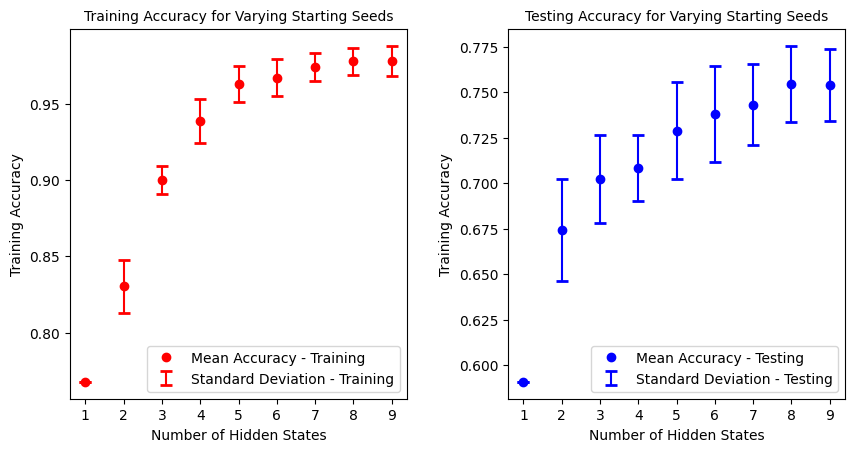

In [622]:
#plot the mean accuracies (with error bars) for the training and testing data
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, top=0.85, wspace=0.3)
axes[0].set_title("Training Accuracy for Varying Starting Seeds", fontsize=10)
axes[1].set_title("Testing Accuracy for Varying Starting Seeds", fontsize=10)

axes[0].plot(hidden_states_set, average_accuracies_train, 'o', color='red', alpha=1, label='Mean Accuracy - Training')
axes[0].errorbar(hidden_states_set, average_accuracies_train, yerr=std_accuracies_train, fmt='none', ecolor='red', capsize=4, capthick=2, label='Standard Deviation - Training')

axes[1].plot(hidden_states_set, average_accuracies_test, 'o', color='blue', alpha=1, label='Mean Accuracy - Testing')
axes[1].errorbar(hidden_states_set, average_accuracies_test, yerr=std_accuracies_test, fmt='none', ecolor='blue', capsize=4, capthick=2, label='Standard Deviation - Testing')

axes[0].set_xticks(hidden_states_set)
axes[0].set_xlabel("Number of Hidden States")
axes[0].set_ylabel("Training Accuracy")
axes[0].legend()

axes[1].set_xticks(hidden_states_set)
axes[1].set_xlabel("Number of Hidden States")
axes[1].set_ylabel("Training Accuracy")
axes[1].legend()
plt.show()

In [30]:
#print the standard deviations and the maximum standard deviations
formatted_std = [f'{std:.3f}' for std in std_accuracies_test]
formatted_string_std = ', '.join(formatted_std)
print(f'Standard Deviations, Test: {formatted_string_std}')

formatted_std = [f'{std:.3f}' for std in std_accuracies_test]
formatted_string_std = ', '.join(formatted_std)
print(f'Standard Deviations, Train: {formatted_string_std}')

print(f'Standard Deviation MAX, Train: {max(std_accuracies_train):.3f}')
print(f'Standard Deviation MAX, Test: {max(std_accuracies_test):.3f}')

Standard Deviations, Test: 0.000, 0.040, 0.030, 0.032, 0.031, 0.031, 0.025, 0.019, 0.022
Standard Deviations, Train: 0.000, 0.040, 0.030, 0.032, 0.031, 0.031, 0.025, 0.019, 0.022
Standard Deviation MAX, Train: 0.023
Standard Deviation MAX, Test: 0.040


The above cells show the mean and standard deviations for the model accuracy on both the training and testing datasets. We clearly see that other than for $\texttt{hidden\_states} = 1$, changing the starting seed value produces accuracy variations in range of $\sigma = 0.023$ for training and $\sigma = 0.040$ for testing. For the remaining experiments, I will fix the starting seed.

### Modifying the Covariance Type

The $\texttt{GaussianHMM}$ model in $\texttt{hmmlearn}$ assumes that for each hidden state ($s \in \mathcal{S}$), the observation ($o \in \mathcal{O}$) are generated from multivariate Gaussian distributions [(Natsume, 2022)](#mblog). Each multivariate Gaussian distribution is defined by a multivariate mean and covariance matrix [(Natsume, 2022)](#mblog). $\texttt{hmmlearn}$ allows the user to define the restrictions placed on the covariance matrices by defining different covariance types ($\texttt{cov\_type}$) [(Natsume, 2022)](#mblog):

1. $\texttt{cov\_type} = \texttt{"diag"}$: the covariance matrix for each hidden state only contains diagonal terms;
2. $\texttt{cov\_type} = \texttt{"spherical"}$: the covariance matrix for each hidden state is of the form $\mathbf{C} = \lambda \mathbf{I}$
3. $\texttt{cov\_type} = \texttt{"full"}$: no restrictions are placed on the covariance matrices
4. $\texttt{cov\_type} = \texttt{"tied"}$: all hidden states share the same matrix however no restrictions are placed on the covariance matrix

In the next cells, I will determine which covariance type yields the highest accuracy. Once again, I will used the same testing and training data for consistency. I will also perform the next set of experiments for all the hidden states previously studied. This will allow us to determine if there is a correlation between the optimal covariance type and the number of hidden states.

#### References
<a id=mblog></a>
Y. Natsume. (2022, April 25). Hidden Markov Models with Python: Modelling Sequential Data Stochastically. https://medium.com/@natsunoyuki/hidden-markov-models-with-python-c026f778dfa7.

In [31]:
%%capture
#analyze the effect of changing the model type and the covariance type
#model parameters
model_name_set = 'GaussianHMM'
cov_type_set = ['diag','spherical','full','tied']
start_state = 1
hidden_states_max = round(total_obs*split)
hidden_states_set = [i for i in range(1,hidden_states_max+1)]

#initialize arrays
accuracies_test = {}
real_labels_all_test = {}
predicted_labels_all_test = {}
#------------------------
accuracies_train = {}
real_labels_all_train = {}
predicted_labels_all_train = {}

#iterate through all the covariance matrix types
for cov_type in cov_type_set:
    print(f'Covariance Matrix Type: {cov_type}')
    accuracies_test[cov_type] = []
    accuracies_train[cov_type] = []
    #iterate through all the numbers of hidden states
    for hidden_states in hidden_states_set:
        trained_models, conv_bool_set, _ = model_training(hidden_states=hidden_states,
                                                          model_name=model_name,
                                                          cov_type=cov_type,
                                                          start_state=start_state,
                                                          train_data=train_data_concatenated,
                                                          train_lengths=train_lengths)
    
        real_labels_train, predicted_labels_train = model_testing(trained_models=trained_models,
                                                                  data=train_data)
    
        real_labels_test, predicted_labels_test = model_testing(trained_models=trained_models,
                                                                data=test_data)
        
        print(f'Number of Hidden States: {hidden_states}')
        print_convergence(conv_bool_set)
        
        #store the labels
        accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
        accuracies_test[cov_type].append(accuracy_test)
        real_labels_all_test[(cov_type, hidden_states)] = real_labels_test
        predicted_labels_all_test[(cov_type, hidden_states)] = predicted_labels_test

        accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
        accuracies_train[cov_type].append(accuracy_train)
        real_labels_all_train[(cov_type, hidden_states)] = real_labels_train
        predicted_labels_all_train[(cov_type, hidden_states)] = predicted_labels_train

In [32]:
np.save('search/old_accuracies_train.npy', accuracies_train)
np.save('search/old_accuracies_test.npy', accuracies_test)

In [33]:
old_accuracies_train = np.load(f'search/old_accuracies_train.npy', allow_pickle=True).item()
old_accuracies_test = np.load(f'search/old_accuracies_test.npy', allow_pickle=True).item()

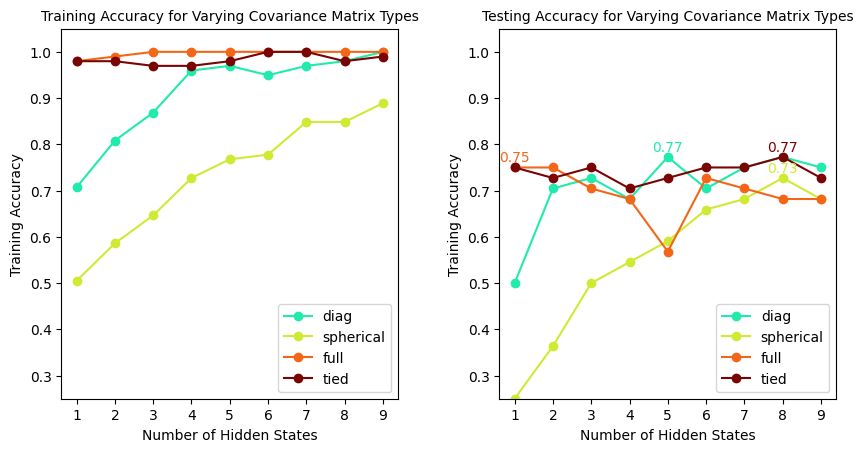

In [37]:
#plot the training and testing accuracies for different covariance types and numbers of hidden states
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, top=0.85, wspace=0.3)
colormap = plt.colormaps['turbo']
color_offset = 0.35

axes[0].set_title("Training Accuracy for Varying Covariance Matrix Types", fontsize=10)
axes[1].set_title("Testing Accuracy for Varying Covariance Matrix Types", fontsize=10)

for cidx, cov_type in enumerate(cov_type_set):
    color_value = (cidx / (len(cov_type_set) - 1)) * (1 - color_offset) + color_offset
    color = colormap(color_value)
    axes[0].plot(hidden_states_set, accuracies_train[cov_type], "-o", color=color, label=cov_type)

for cidx, cov_type in enumerate(cov_type_set):
    color_value = (cidx / (len(cov_type_set) - 1)) * (1 - color_offset) + color_offset
    color = colormap(color_value)
    axes[1].plot(hidden_states_set, accuracies_test[cov_type], "-o", color=color, label=cov_type)
    max_test = max(accuracies_test[cov_type])
    max_idx_test = accuracies_test[cov_type].index(max_test)
    axes[1].annotate(f'{max_test:.2f}', xy=(hidden_states_set[max_idx_test], max_test),
                xytext=(0, 2), textcoords='offset points', ha='center', va='bottom', color=color)

axes[0].set_xticks(hidden_states_set)
axes[1].set_xticks(hidden_states_set)

axes[0].set_ylim(ymin=0.20, ymax= 1.05)
axes[1].set_ylim(ymin=0.20, ymax = 1.05)

axes[0].set_xlabel("Number of Hidden States")
axes[0].set_ylabel("Training Accuracy")
axes[1].set_xlabel("Number of Hidden States")
axes[1].set_ylabel("Training Accuracy")

axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')

plt.show()

In [38]:
#print the accuracies for each cov-type
for cov_type in cov_type_set:
    formatted_accuracies = [f'{accuracy:.3f}' for accuracy in old_accuracies_test[cov_type]]
    formatted_string = ', '.join(formatted_accuracies)
    print(f'Cov-Type: {cov_type: <9} | Mean: {formatted_string}')

Cov-Type: diag      | Mean: 0.500, 0.705, 0.727, 0.682, 0.773, 0.705, 0.750, 0.773, 0.750
Cov-Type: spherical | Mean: 0.250, 0.364, 0.500, 0.545, 0.591, 0.659, 0.682, 0.727, 0.682
Cov-Type: full      | Mean: 0.750, 0.750, 0.705, 0.682, 0.568, 0.727, 0.705, 0.682, 0.682
Cov-Type: tied      | Mean: 0.750, 0.727, 0.750, 0.705, 0.727, 0.750, 0.750, 0.773, 0.727


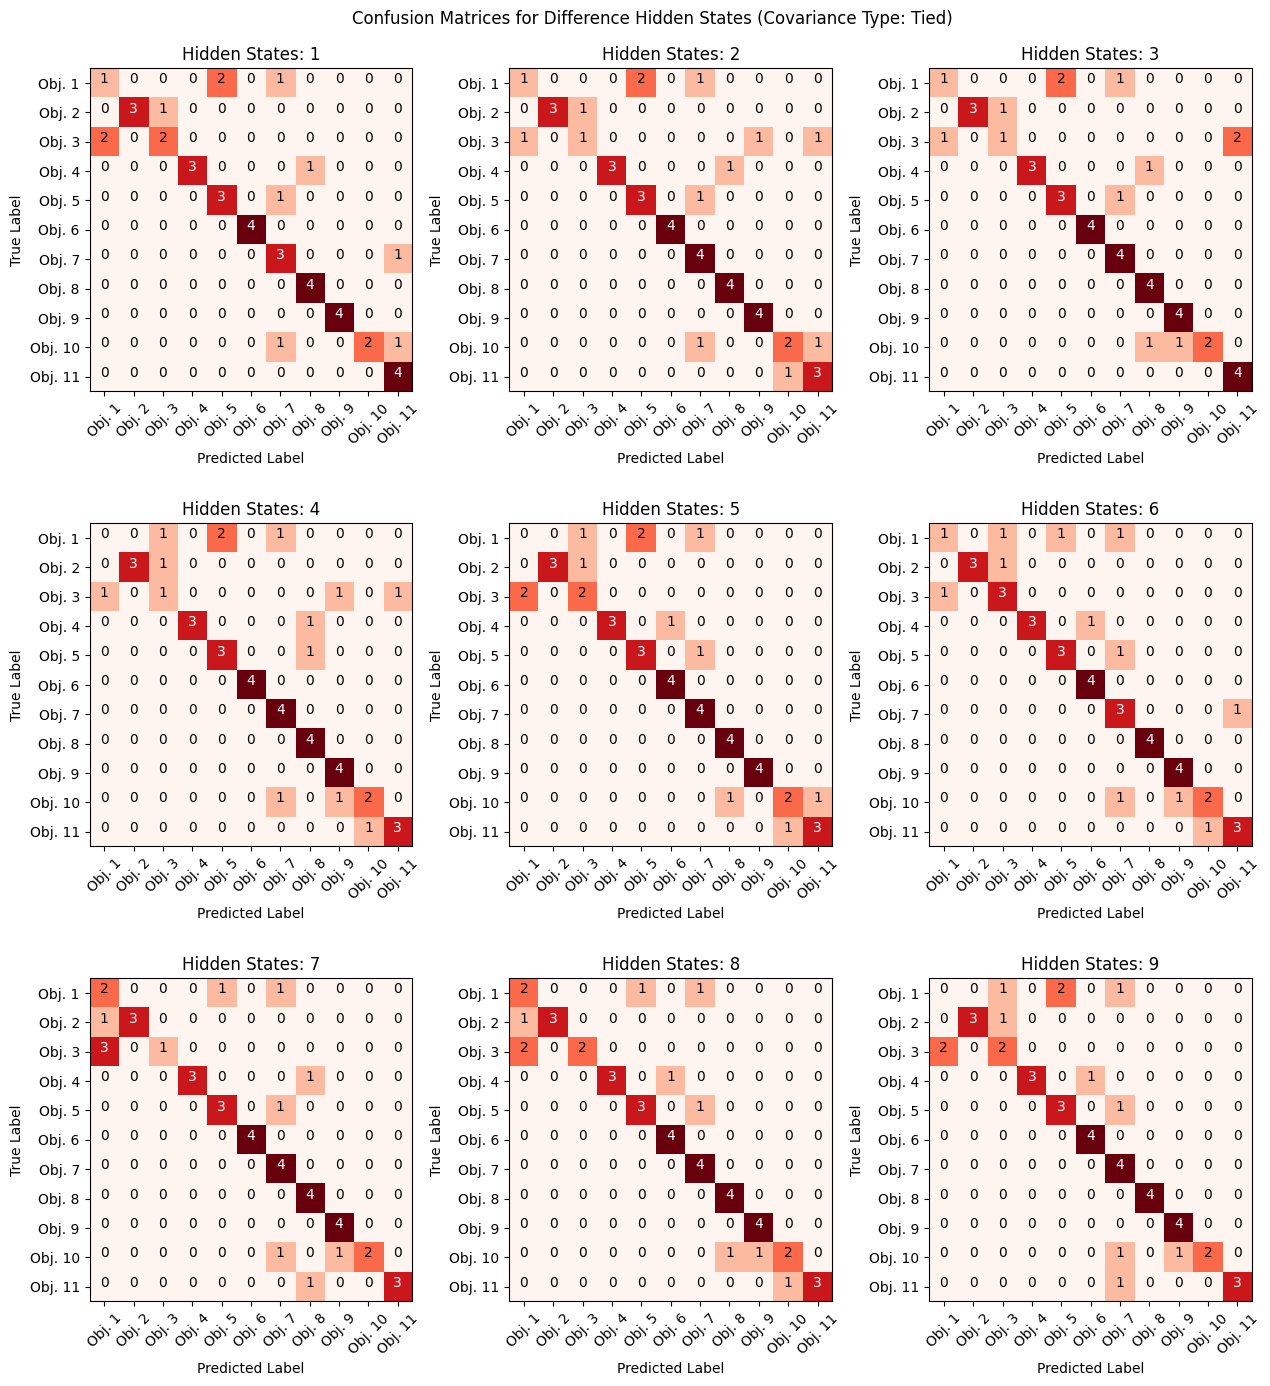

In [39]:
#generate the confusion matrices
objects = 11
cov_type = 'tied'
object_set = [i for i in range(1, objects + 1)]
classes = [f'Obj. {i}' for i in object_set]

num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.3, top=0.95, wspace=0.3)
fig.suptitle('Confusion Matrices for Difference Hidden States (Covariance Type: Tied)')

for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    cm = confusion_matrix(real_labels_all_test[(cov_type, hidden_states)], predicted_labels_all_test[(cov_type, hidden_states)], labels=classes)
    title=f'Hidden States: {hidden_states}'
    plot_confusion_matrix(axes[row_idx, col_idx], cm, classes, title=title, normalize=False)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

plt.show()

The experiments indicate that the accuracy of $\texttt{cov\_type} = {\texttt{tied}}$ is the most consistent; it results in the highest (or joint highest) accuracy for $6/9$ hidden states. $\texttt{cov\_type} = {\texttt{spherical}}$ consistently has the worst accuracy. $\texttt{cov\_type} = {\texttt{diag}}$ should be considered as an option if computational speed is prioritized. For the remaining experiments, we will used $\texttt{cov\_type} = {\texttt{tied}}$, since it appears to give stable accuracies across all hidden states, allowing us to continue to experiment with the number of hidden states as a parameter.

### Textural Uniqueness
As previously mentioned, here are multiple object pairs in the dataset with the same texture but different colors. Since a purely acoustic-based classifier can not distinguish between colors, it is unlikely that it can correctly classify these object pairs. We will now modify the $\texttt{data\_extraction}(~)$ function to explicitly account for textural uniqueness. In other words, we consider objects with the same textures as being part of the same class. Specifically, the following objects will be considered as part of the same textural classes:

| Objects | Description |
| :---: | :---: |
| 1, 3 |  Baseballs |
| 4, 8 | Expressive Balls |
| 2, 11 | Mesh Loofahs |
| 9, 11 | Foam Block and Sphere |

In [42]:
def model_testing_new(trained_models, data):
    #estimate the label of each time-series in the testing dataset
    #fixed parameters
    objects = 11
    
    #initialize arrays
    predicted_labels = []
    real_labels = []

    #iterate over all objects
    for object_num in range(1, objects + 1):
        #iterate over all observation sequences for each object
        for obs_sequence in data[object_num]:
            #predict the likelihood that an observation sequence comes from the models corresponding to each object
            for object_num_sub in range(1, objects + 1):
                trained_model = trained_models[object_num_sub]
                curr_score = trained_model.observation_likelihood(obs_sequence)
                #keep track of the model which yields the highest likelihood
                if object_num_sub == 1:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
                elif curr_score > highest_score:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub

            #correct for textural uniqueness by combining predicted and real labels from certain pairs of objects
            if object_num == 3:
                object_num_corr = 1
            elif object_num == 11:
                object_num_corr = 2
            elif object_num == 8:
                object_num_corr = 4
            elif object_num == 10:
                object_num_corr = 9
            else:
                object_num_corr = object_num
                
            if highest_likelihood_object == 3:
                highest_likelihood_object_corr = 1
            elif highest_likelihood_object == 11:
                highest_likelihood_object_corr = 2
            elif highest_likelihood_object == 8:
                highest_likelihood_object_corr = 4
            elif highest_likelihood_object == 10:
                highest_likelihood_object_corr = 9
            else:
                highest_likelihood_object_corr = highest_likelihood_object

            #store the labels
            real_labels.append(f'Obj. {object_num_corr}')
            predicted_labels.append(f'Obj. {highest_likelihood_object_corr}')
    
    return real_labels, predicted_labels

In [43]:
%%capture
#analyze the affect of accounting for textural uniqueness
#model parameters
model_name = 'GaussianHMM'
cov_type = 'tied'
start_state = 1

#initialize arrays
accuracies_train_new = []
real_labels_all_train_new = {}
predicted_labels_all_train_new = {}
#------------------------------
accuracies_test_new = []
real_labels_all_test_new = {}
predicted_labels_all_test_new = {}

#iterate over different numbers of hidden states
for hidden_states in hidden_states_set:
    trained_models, conv_bool_set, _ = model_training(hidden_states=hidden_states,
                                                      model_name=model_name,
                                                      cov_type=cov_type,
                                                      start_state=start_state,
                                                      train_data=train_data_concatenated,
                                                      train_lengths=train_lengths)
    
    real_labels_train, predicted_labels_train = model_testing_new(trained_models=trained_models,
                                                                  data=train_data)
    
    real_labels_test, predicted_labels_test = model_testing_new(trained_models=trained_models,
                                                                data=test_data)
    
    print(f'Number of Hidden States: {hidden_states}')
    print_convergence(conv_bool_set)
    
    #store the labels
    accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
    accuracies_test_new.append(accuracy_test)
    real_labels_all_test_new[hidden_states] = real_labels_test
    predicted_labels_all_test_new[hidden_states] = predicted_labels_test

    accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
    accuracies_train_new.append(accuracy_train)
    real_labels_all_train_new[hidden_states] = real_labels_train
    predicted_labels_all_train_new[hidden_states] = predicted_labels_train

In [44]:
np.save('search/new_accuracies_train.npy', accuracies_train_new)
np.save('search/new_accuracies_test.npy', accuracies_test_new)

In [45]:
new_accuracies_train = np.load(f'search/new_accuracies_train.npy', allow_pickle=True)
new_accuracies_test = np.load(f'search/new_accuracies_test.npy', allow_pickle=True)

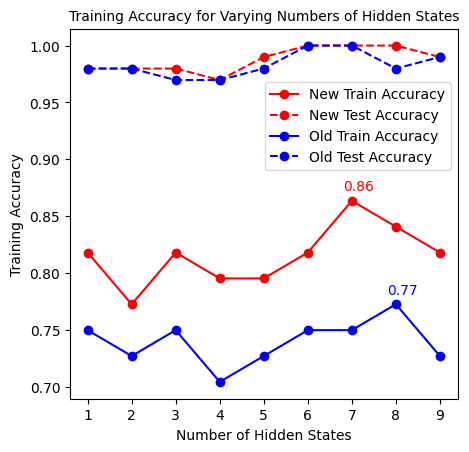

In [55]:
#plot the training and testing accuracies before and after accounting for textural uniqueness
fig, axes = plt.subplots(1, 1, figsize=(5,5))
fig.subplots_adjust(hspace=0.2, top=0.85, wspace=0.3)
axes.set_title("Training Accuracy for Varying Numbers of Hidden States", fontsize=10)
axes.plot(hidden_states_set, new_accuracies_test, "-o", color='red', label='New Train Accuracy')
axes.plot(hidden_states_set, new_accuracies_train, "--o", color='red', label='New Test Accuracy')
axes.plot(hidden_states_set, old_accuracies_test[cov_type], "-o", color='blue', label='Old Train Accuracy')
axes.plot(hidden_states_set, old_accuracies_train[cov_type], "--o", color='blue', label='Old Test Accuracy')

max_test_old = max(old_accuracies_test[cov_type])
max_test_new = max(new_accuracies_test)

max_idx_test_old = np.argmax(old_accuracies_test[cov_type])
max_idx_test_new = np.argmax(new_accuracies_test)

axes.annotate(f'{max_test_old:.2f}', xy=(hidden_states_set[max_idx_test_old], max_test_old),
              xytext=(5, 5), textcoords='offset points', ha='center', va='bottom', color='blue')
axes.annotate(f'{max_test_new:.2f}', xy=(hidden_states_set[max_idx_test_new], max_test_new),
              xytext=(5, 5), textcoords='offset points', ha='center', va='bottom', color='red')


axes.set_xticks(hidden_states_set)
axes.legend(loc='upper right', bbox_to_anchor=[1,0.875])
axes.set_xlabel("Number of Hidden States")
axes.set_ylabel("Training Accuracy")

plt.show()

As expected, accounting for textural uniqueness increases the accuracy of the classifier. In the remaining, textural uniqueness will be taken into account.

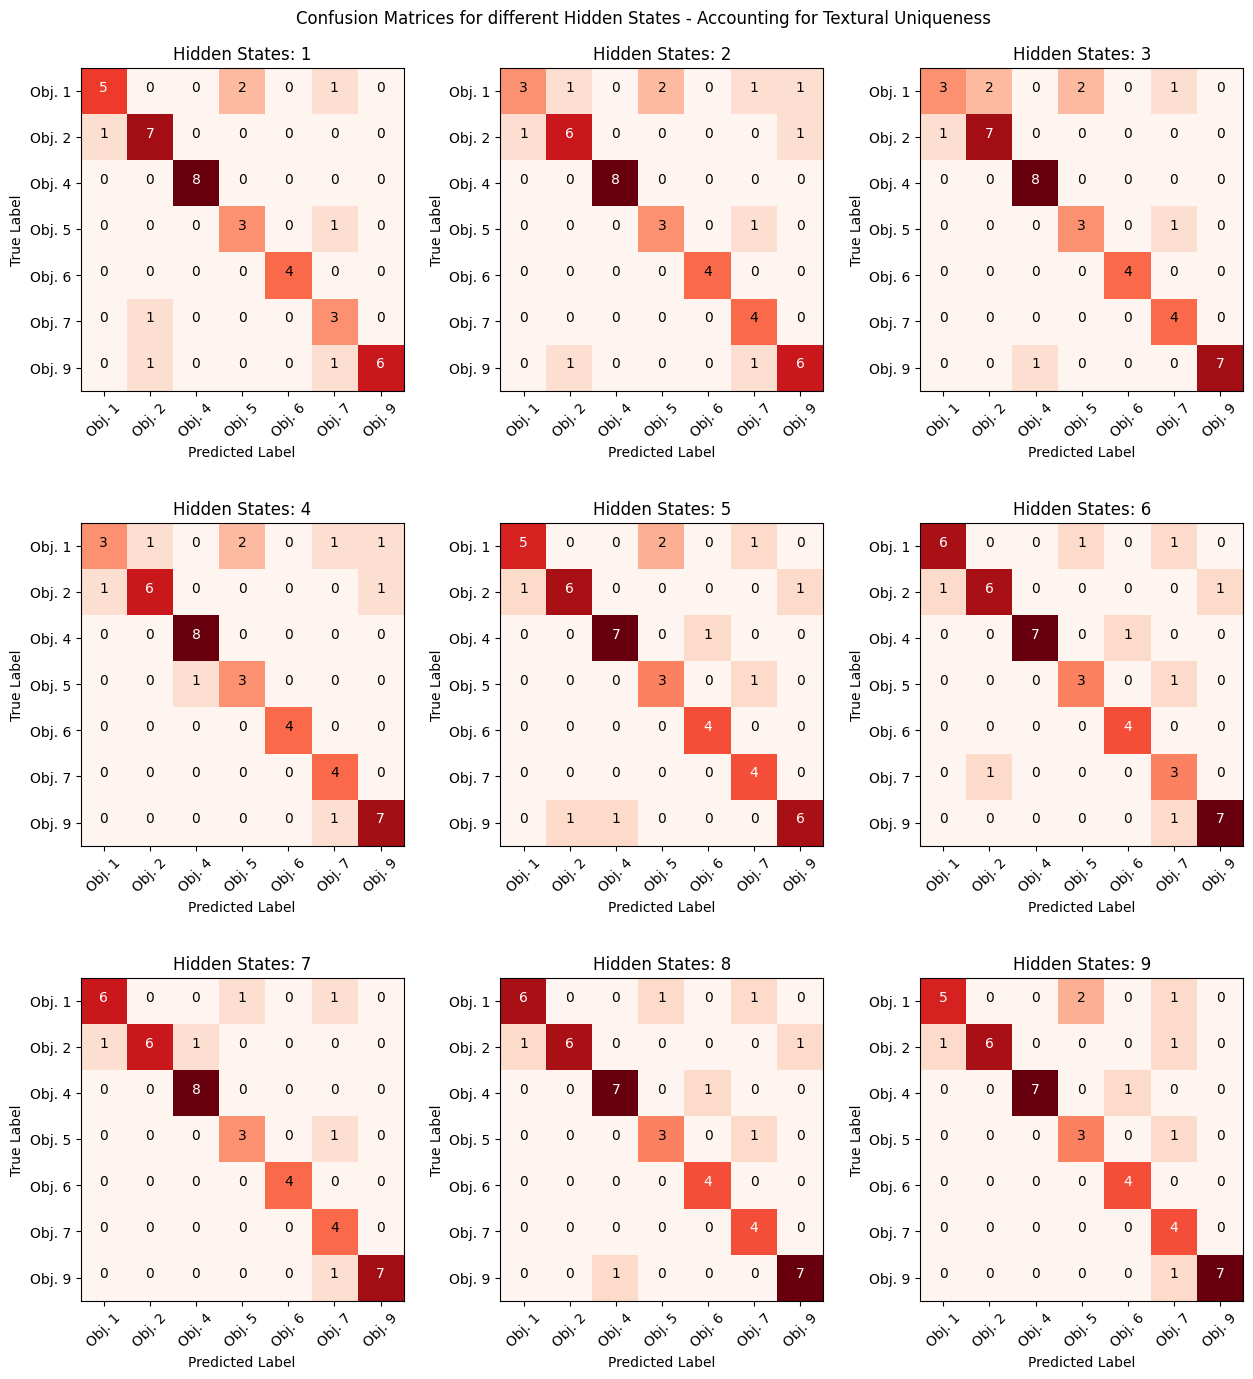

In [56]:
#generate the confusion matrices
objects = 11
cov_type = 'tied'
object_set = [1,2,4,5,6,7,9]
classes = [f'Obj. {i}' for i in object_set]

num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.3, top=0.95, wspace=0.3)
fig.suptitle('Confusion Matrices for different Hidden States - Accounting for Textural Uniqueness')

for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    cm = confusion_matrix(real_labels_all_test_new[hidden_states], predicted_labels_all_test_new[hidden_states], labels=classes)
    title = f'Hidden States: {hidden_states}'
    plot_confusion_matrix(axes[row_idx, col_idx], cm, classes, title=title, normalize=False)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

plt.show()

Observing the confusion matrices above, we again note that taking textural uniqueness into account increases the accuracy of the classifier, resulting in fewer misclassifications.

### Further Optimization of the Algorithm
Two features of the algorithm that we have not experimented with are the number of MFCC components and the parameters used to compute the Fourier Transform:
1. $\texttt{window\_factor}$: size of the sliding window, defined as the fraction of the full signal
2. $\texttt{padding\_factor}$: the amount of padding adding to windowed data before computing the Fourier Transform, defined as a multiplier in powers of two
3. $\texttt{hop\_factor}$: the amount of overlap between windows, defined as a fraction of the window-size

 In the previous set of results, I used default value for each of these parameters (except for the number of MFCC components which was set to 15). Given our baseline model-in which $\texttt{cov\_type}$ and $\texttt{model\_type = "GaussianHMM"}$ are fixed-we can now explore the effect of changing these parameters. 

In [57]:
def split_data_fix(data, lengths, train_nums, test_nums):
    #define modified version of split_data() to use previous training/testing set
    #split the data based on explicit train and test observation numbers (pre-defined)
    #fixed parameters
    objects = 11

    train_data = {}
    test_data = {}

    train_lengths = {}
    test_lengths = {}

    for object_num in range(1, objects + 1):
        train_data[object_num] = []
        train_lengths[object_num] = []
        test_data[object_num] = []
        test_lengths[object_num] = []
        for obs in train_nums:
            train_data[object_num].append(data[(object_num, obs)])
            train_lengths[object_num].append(lengths[(object_num, obs)])
        for obs in test_nums:
            test_data[object_num].append(data[(object_num, obs)])
            test_lengths[object_num].append(lengths[(object_num, obs)])

    return train_data, test_data, train_lengths, test_lengths

In [59]:
#test/train observation sets from previous experiments
train_nums = [12, 13, 4, 10, 9, 3, 7, 8, 6]
test_nums = [11, 1, 2, 5]

In [60]:
#define the parameter space
mfcc_features_set = [5, 10, 15, 25, 35, 45, 55, 65]
window_factor_set = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
hidden_states_set = [3, 4, 5, 6, 7, 8]

### A Note on Parrallelization
In the parameter search I have defined, I need to train and test $8 \times 8 \times 6 = 384$ models. To reduce the run-time, I have implemented a multi-threading scheme which parallelizes the training and testing code.

<span style="color:yellow">Note:</span> do not run the cells below (the run-time is ~45 min), one can directly load and visualize the results

In [61]:
#import models for multi-threading and locking
import concurrent.futures
import threading

In [67]:
%%capture
#parameter search (with parallelization)
class AccuracyMatrixUpdater:
    def __init__(self, hidden_states_set, mfcc_features_set, window_factor_set, train_nums, test_nums):
        #fixed parameters
        self.objects = 11
        self.hop_factor = 0.2
        self.padding_factor = 1
        self.channel = 0
        self.scaling = True

        self.train_nums = train_nums
        self.test_nums = test_nums

        self.model_name = 'GaussianHMM'
        self.cov_type = 'tied'
        self.start_state = 1
        
        self.hidden_states_set = hidden_states_set
        self.mfcc_features_set = mfcc_features_set
        self.window_factor_set = window_factor_set
        
        #initialization
        self.accuracies_train = {}
        self.accuracies_test = {}

        for hidden_states in hidden_states_set:
            self.accuracies_train[hidden_states] = [[0.0] * len(window_factor_set) for _ in range(len(mfcc_features_set))]
            self.accuracies_test[hidden_states] = [[0.0] * len(window_factor_set) for _ in range(len(mfcc_features_set))]


        self.lock = threading.Lock()

    def update_accuracies(self, hidden_states, mfcc_idx, window_idx, accuracy_train, accuracy_test):
        #function to update accuracy matrices
        with self.lock:
            self.accuracies_train[hidden_states][mfcc_idx][window_idx] = accuracy_train
            self.accuracies_test[hidden_states][mfcc_idx][window_idx] = accuracy_test

    def process_combination(self, hidden_states, mfcc_idx, window_idx):
        #calculate accuracy_train and accuracy_test
        data, lengths = data_extraction(channel=self.channel,
                                        mfcc_features=self.mfcc_features_set[mfcc_idx],
                                        window_factor=self.window_factor_set[window_idx],
                                        padding_factor=self.padding_factor,
                                        hop_factor=self.hop_factor,
                                        default_config=False,                                                        
                                        scaling=self.scaling) 

        train_data, test_data, train_lengths, _ = split_data_fix(data=data,
                                                                 lengths=lengths,
                                                                 train_nums=self.train_nums,
                                                                 test_nums=self.test_nums)
        
        train_data_concatenated = concatenate_data(train_data)                                                             

        trained_models, _ , _ = model_training(hidden_states=hidden_states,
                                               model_name=self.model_name,
                                               cov_type=self.cov_type,
                                               start_state=self.start_state,
                                               train_data=train_data_concatenated,
                                               train_lengths=train_lengths)
            
        real_labels_train, predicted_labels_train = model_testing_new(trained_models=trained_models,
                                                                      data=train_data)
            
        real_labels_test, predicted_labels_test = model_testing_new(trained_models=trained_models,
                                                                    data=test_data)
            
        accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
        accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
        
        #update accuracies
        self.update_accuracies(hidden_states, mfcc_idx, window_idx, accuracy_train, accuracy_test)


accuracy_matrix_updater = AccuracyMatrixUpdater(hidden_states_set=hidden_states_set,
                                                mfcc_features_set=mfcc_features_set,
                                                window_factor_set=window_factor_set,
                                                train_nums=train_nums,
                                                test_nums=test_nums)

#number of threads to use
num_workers = 8

#create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    #iterate over the combinations
    futures = []
    for hidden_states in hidden_states_set:
        for mfcc_idx, mfcc_features in enumerate(mfcc_features_set):
            for window_idx, window_factor in enumerate(window_factor_set):
                future = executor.submit(
                    accuracy_matrix_updater.process_combination, hidden_states, mfcc_idx, window_idx
                )
                futures.append(future)

    #wait for all computations to finish
    concurrent.futures.wait(futures)

#access the results
accuracies_test = accuracy_matrix_updater.accuracies_test
accuracies_train = accuracy_matrix_updater.accuracies_train
    

In [68]:
#save the results: DO NOT RUN THIS
np.save('search/parameter_accuracies_train_____.npy', accuracies_train_____)
np.save('search/parameter_accuracies_test_____.npy', accuracies_test_______)

In [69]:
accuracies_train = np.load(f'search/parameter_accuracies_train.npy', allow_pickle=True).item()
accuracies_test = np.load(f'search/parameter_accuracies_test.npy', allow_pickle=True).item()

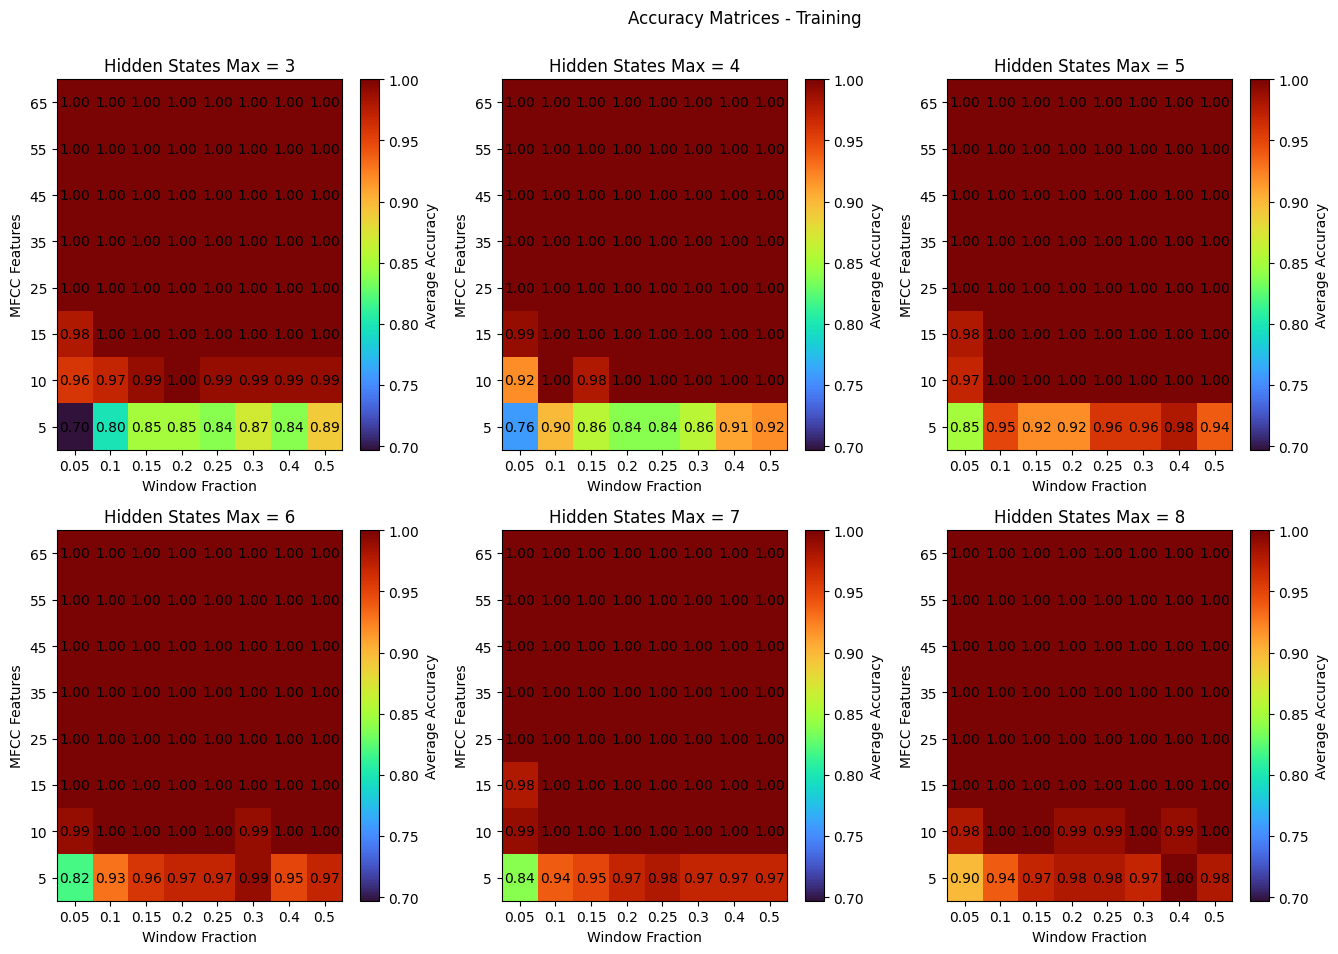

In [70]:
#plot accuracy matrices for different parameter combinations
#calculate global minimum and maximum values across all hidden states
global_min_acc = []
global_max_acc = []
for hidden_states in hidden_states_set:
    global_min_acc.append(np.min(accuracies_train[hidden_states]))
    global_max_acc.append(np.max(accuracies_train[hidden_states]))
global_min_acc_val = min(global_min_acc)
global_max_acc_val = max(global_max_acc)

#plotting Accuracy Matrices
num_cols = 3
num_cols = min(num_cols, len(hidden_states_set))
num_rows = int(np.ceil(len(hidden_states_set) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle(f'Accuracy Matrices - Training', y=0.95)

for hidx, hidden_states in enumerate(hidden_states_set):
    accuracy_matrix = accuracies_train[hidden_states]

    ax = axes.flatten()[hidx]
    im = ax.pcolormesh(np.arange(len(window_factor_set) + 1), np.arange(len(mfcc_features_set) + 1), accuracy_matrix, shading='auto', cmap='turbo', vmin=global_min_acc_val, vmax=global_max_acc_val)

    ax.set_xticks(np.arange(len(window_factor_set)) + 0.5)
    ax.set_yticks(np.arange(len(mfcc_features_set)) + 0.5)

    ax.set_xticklabels([str(i) for i in window_factor_set])
    ax.set_yticklabels([str(i) for i in mfcc_features_set])

    cbar = fig.colorbar(im, ax=ax, label='Average Accuracy')

    ax.set_xlabel('Window Fraction')
    ax.set_ylabel('MFCC Features')
    ax.set_title(f'Hidden States Max = {hidden_states}')

    # Add text annotations inside each box
    for i in range(len(window_factor_set)):
        for j in range(len(mfcc_features_set)):
            text = f'{accuracy_matrix[j][i]:.2f}'
            ax.text(i + 0.5, j + 0.5, text, ha='center', va='center', color='black')

#remove unused subplots
for i in range(len(hidden_states_set), num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

The matrices above show the training accuracy for different parameter combinations. Besides for a small number of MFCC features and/or very small window fractions, the training accuracy is very high.

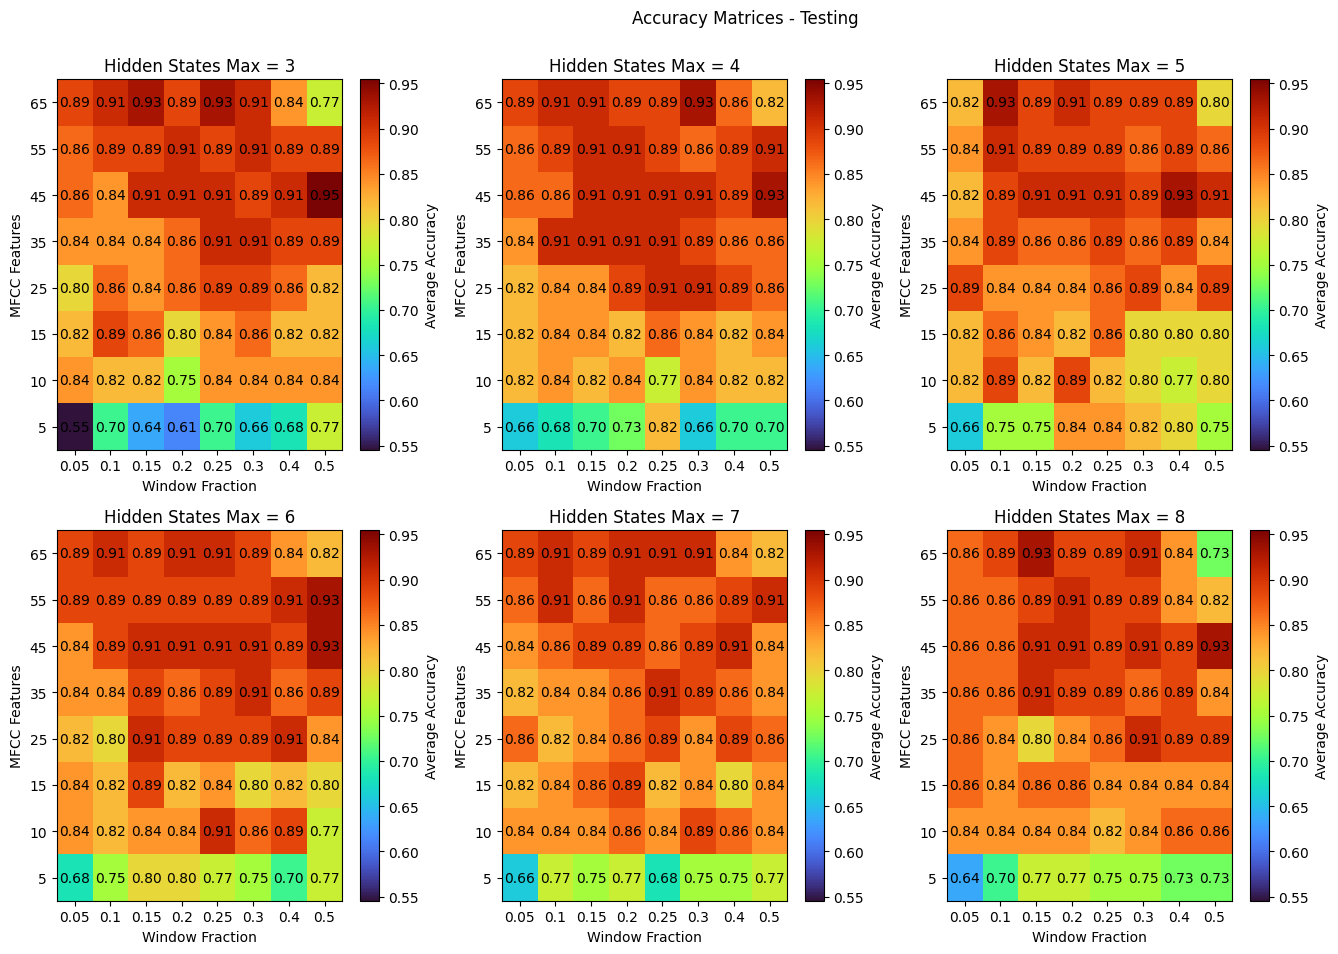

In [71]:
#plot accuracy matrices for different parameter combinations
#calculate global minimum and maximum values across all hidden states
global_min_acc = []
global_max_acc = []
for hidden_states in hidden_states_set:
    global_min_acc.append(np.min(accuracies_test[hidden_states]))
    global_max_acc.append(np.max(accuracies_test[hidden_states]))
global_min_acc_val = min(global_min_acc)
global_max_acc_val = max(global_max_acc)

#plotting Accuracy Matrices
num_cols = 3
num_cols = min(num_cols, len(hidden_states_set))
num_rows = int(np.ceil(len(hidden_states_set) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle(f'Accuracy Matrices - Testing', y=0.95)

for hidx, hidden_states in enumerate(hidden_states_set):
    accuracy_matrix = accuracies_test[hidden_states]

    ax = axes.flatten()[hidx]
    im = ax.pcolormesh(np.arange(len(window_factor_set) + 1), np.arange(len(mfcc_features_set) + 1), accuracy_matrix, shading='auto', cmap='turbo', vmin=global_min_acc_val, vmax=global_max_acc_val)

    ax.set_xticks(np.arange(len(window_factor_set)) + 0.5)
    ax.set_yticks(np.arange(len(mfcc_features_set)) + 0.5)

    ax.set_xticklabels([str(i) for i in window_factor_set])
    ax.set_yticklabels([str(i) for i in mfcc_features_set])

    cbar = fig.colorbar(im, ax=ax, label='Average Accuracy')

    ax.set_xlabel('Window Fraction')
    ax.set_ylabel('MFCC Features')
    ax.set_title(f'Hidden States Max = {hidden_states}')

    # Add text annotations inside each box
    for i in range(len(window_factor_set)):
        for j in range(len(mfcc_features_set)):
            text = f'{accuracy_matrix[j][i]:.2f}'
            ax.text(i + 0.5, j + 0.5, text, ha='center', va='center', color='black')

#remove unused subplots
for i in range(len(hidden_states_set), num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

The matrices above show the testing accuracy for all the combinations of the parameters sets. We see that one the highest accuracies for all hidden states consistently appears at a $\texttt{window\_fraction}=0.2$ and $\texttt{mfcc\_features}=45$. We select these parameters for the next set of experiments.

### Final Set of Experiments
Given the small size of the dataset, it is necessary to perform cross validation. With the constraint that the training set must contain two 'real' observations and the testing set must contain one 'real' observation, we have $3\cdot{10 \choose 3}=360$ unique ways of distributing the observations in a $0.70/0.30$ split.

<span style="color:yellow">Note:</span> do not run the cells below (the run-time is ~325 min)

In [72]:
#generate all possible train/test set combinations
#indices of real and ideal observations
real_obs = list(range(11, 14))
ideal_obs = list(range(1, 11))

def missing_values(nums):
    #function to find the ideal observation numbers not in a given list of seven
    ideal_obs = set(range(1, 11))
    missing_numbers = ideal_obs - set(nums)
    return list(missing_numbers)

#find all combination (10 choose 7)
gs7 = list(itertools.combinations(ideal_obs, 7))

gs3 = []
#store the missing value (for testing)
for g7 in gs7:
    g3 = missing_values(g7)
    gs3.append(g3)

#convert tuples to lists
gs7 = [list(g7) for g7 in gs7]

all_sequences = []
#create all unique sequences
for idx, g3 in enumerate(gs3):
    for obs in real_obs:
        sequence = gs7[idx].copy()
        sequence.extend([val for val in real_obs if val != obs])
        sequence.extend(g3)
        sequence.append(obs)
        all_sequences.append(sequence)

#ensure there are 360 unique sequences
print(f'Combinations: {len(all_sequences)}')

Combinations: 360


In [78]:
#define parameter set
mfcc_features = 45
window_factor = 0.2
hidden_states_set = [3,4,5,6,7,8]
n_iterations = 360

In [79]:
%%capture
#experiment: vary the train/test observations sets - cross-validation
#parameter search (with parallelization)
class CrossValidator:
    def __init__(self, all_sequences, n_iterations, mfcc_features, window_factor):
        #fixed parameters
        self.objects = 11
        self.hop_factor = 0.2
        self.padding_factor = 1
        self.channel = 0
        self.scaling = True
        self.split = 0.7

        self.model_name = 'GaussianHMM'
        self.cov_type = 'tied'
        self.start_state = 1

        self.n_iterations = n_iterations
        
        self.mfcc_features = mfcc_features
        self.window_factor = window_factor

        self.all_sequences = all_sequences
        
        #initialize
        self.accuracies_train = {}
        self.accuracies_test = {}

        for hidden_states in hidden_states_set:
            self.accuracies_train[hidden_states] = [0.0 for i in range(0, self.n_iterations)]
            self.accuracies_test[hidden_states] = [0.0 for i in range(0, self.n_iterations)]

        self.lock = threading.Lock()

    def update_accuracies(self, hidden_states, nidx, accuracy_train, accuracy_test):
        #update the accuracy matrices
        with self.lock:
            self.accuracies_train[hidden_states][nidx] = accuracy_train
            self.accuracies_test[hidden_states][nidx] = accuracy_test

    def process_instance(self, hidden_states, nidx):
        #calculate accuracy_train and accuracy_test
        data, lengths = data_extraction(channel=self.channel,
                                        mfcc_features=self.mfcc_features,
                                        window_factor=self.window_factor,
                                        padding_factor=self.padding_factor,
                                        hop_factor=self.hop_factor,
                                        default_config=False,                                                        
                                        scaling=self.scaling) 

        train_data, test_data, train_lengths, _ = split_data_fix(data=data,
                                                                 lengths=lengths, 
                                                                 train_nums=self.all_sequences[nidx][0:9],
                                                                 test_nums=self.all_sequences[nidx][9:13])
        
        train_data_concatenated = concatenate_data(train_data)                                                           

        trained_models, _ , _ = model_training(hidden_states=hidden_states,
                                               model_name=self.model_name,
                                               cov_type=self.cov_type,
                                               start_state=self.start_state,
                                               train_data=train_data_concatenated,
                                               train_lengths=train_lengths)
            
        real_labels_train, predicted_labels_train = model_testing_new(trained_models=trained_models,
                                                                      data=train_data)
            
        real_labels_test, predicted_labels_test = model_testing_new(trained_models=trained_models,
                                                                    data=test_data)
            
        accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
        accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
        
        #update accuracies
        self.update_accuracies(hidden_states, nidx, accuracy_train, accuracy_test)


cv_experiment = CrossValidator(all_sequences=all_sequences,
                               n_iterations=n_iterations,
                               mfcc_features=mfcc_features,
                               window_factor=window_factor)

#number of threads to use
num_workers = 8

#create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    #iterate over the combinations
    futures = []
    for hidden_states in hidden_states_set:
        for nidx in range(0, n_iterations):
            future = executor.submit(cv_experiment.process_instance,
                                     hidden_states=hidden_states,
                                     nidx=nidx)
            futures.append(future)

    #wait for all computations to finish
    concurrent.futures.wait(futures)

#access the results
cv_accuracies_test = cv_experiment.accuracies_test
cv_accuracies_train = cv_experiment.accuracies_train

In [80]:
#save results: DO NOT RUN THIS
np.save('search/cv_accuracies_train_____.npy', cv_accuracies_train_____)
np.save('search/cv_accuracies_test_____.npy', cv_accuracies_test_____)

In [81]:
#access the data that has already been computed
cv_accuracies_train = np.load(f'search/cv_accuracies_train.npy', allow_pickle=True).item()
cv_accuracies_test = np.load(f'search/cv_accuracies_test.npy', allow_pickle=True).item()

In [132]:
#compute average accuracy and standard deviations for the training and testing data across all hidden states
average_accuracies_test = []
std_accuracies_test = []
iqr_test = []
#---------------------------
average_accuracies_train = []
std_accuracies_train = []
iqr_train = []

for hidden_states in hidden_states_set:
    average_accuracies_test.append(sum(cv_accuracies_test[hidden_states]) / n_iterations)
    std_accuracies_test.append(statistics.stdev(cv_accuracies_test[hidden_states]))

for hidden_states in hidden_states_set:
    average_accuracies_train.append(sum(cv_accuracies_train[hidden_states]) / n_iterations)
    std_accuracies_train.append(statistics.stdev(cv_accuracies_train[hidden_states]))

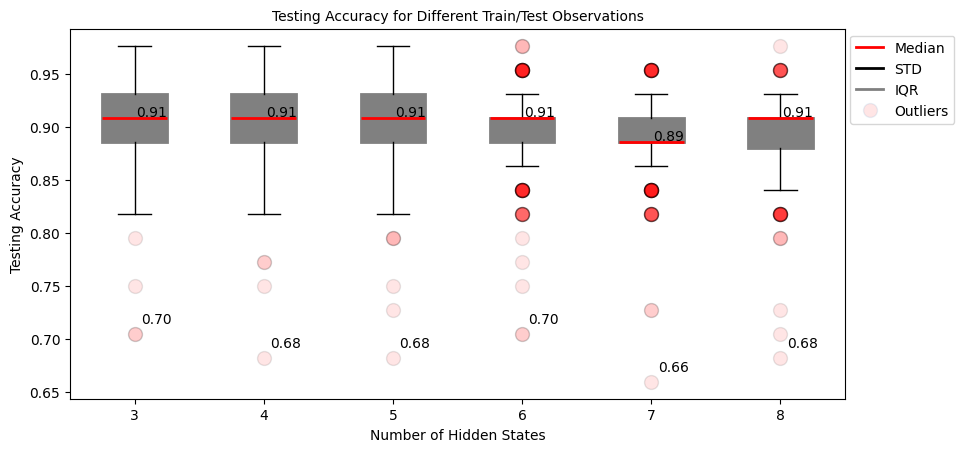

In [185]:
#plot median, IQR and STD
from matplotlib.lines import Line2D

#plot all the accuracies for each number of hidden states, all plot the mean accuracy and error bars (+/- standard deviation)
fig, axes = plt.subplots(1, 1, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, top=0.85, wspace=0.3)
axes.set_title("Testing Accuracy for Different Train/Test Observations", fontsize=10)

boxplot = axes.boxplot(list(cv_accuracies_test.values()),
                       positions=hidden_states_set,
                       patch_artist=True,
                       flierprops={'alpha': 0.1, 'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})

for hidden_states in hidden_states_set:
    min_val = min(cv_accuracies_test[hidden_states])
    axes.annotate(text=f'{min_val:.2f}', xy=(hidden_states, min_val), xytext=(hidden_states+0.05, min_val+0.01))

#customize the colors and linestyles for median, STD, and IQR
median_props = dict(color='red', linestyle='solid', linewidth=2)
std_props = dict(color='black', linestyle='solid', linewidth=2)
iqr_props = dict(color='grey', linestyle='solid', linewidth=2)

#set the properties for STD lines
for element in ['whiskers', 'caps', 'boxes']:
    plt.setp(boxplot[element], color='black')

#set properties for median line
for median in boxplot['medians']:
    median.set(**median_props)
    x, y = median.get_xydata().mean(axis=0)
    axes.annotate(text=f'{median.get_ydata()[0]:.2f}', xy=(x,y), xytext=(x+0.015, y+0.001))

#set properties for outliers
std_flier = boxplot['fliers'][1]

# Set properties for IQR box
for box in boxplot['boxes']:
    box.set(**iqr_props)

# Extract the y-data for outliers
outliers = std_flier.get_ydata()

# Create a custom legend
legend_elements = [
    Line2D([0], [0], **median_props),
    Line2D([0], [0], markerfacecolor='none', markeredgecolor='none', **std_props, label='STD'),
    Line2D([0], [0], **iqr_props),
    Line2D([0], [0], alpha=0.1, marker='o', linestyle='None', markersize=10, markerfacecolor='red', label='Outliers')  # Legend entry for outliers
]

plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=[1.15,1], labels=['Median', 'STD', 'IQR', 'Outliers'])

axes.set_xticks(hidden_states_set)
axes.set_xlabel("Number of Hidden States")
axes.set_ylabel("Testing Accuracy")
plt.show()

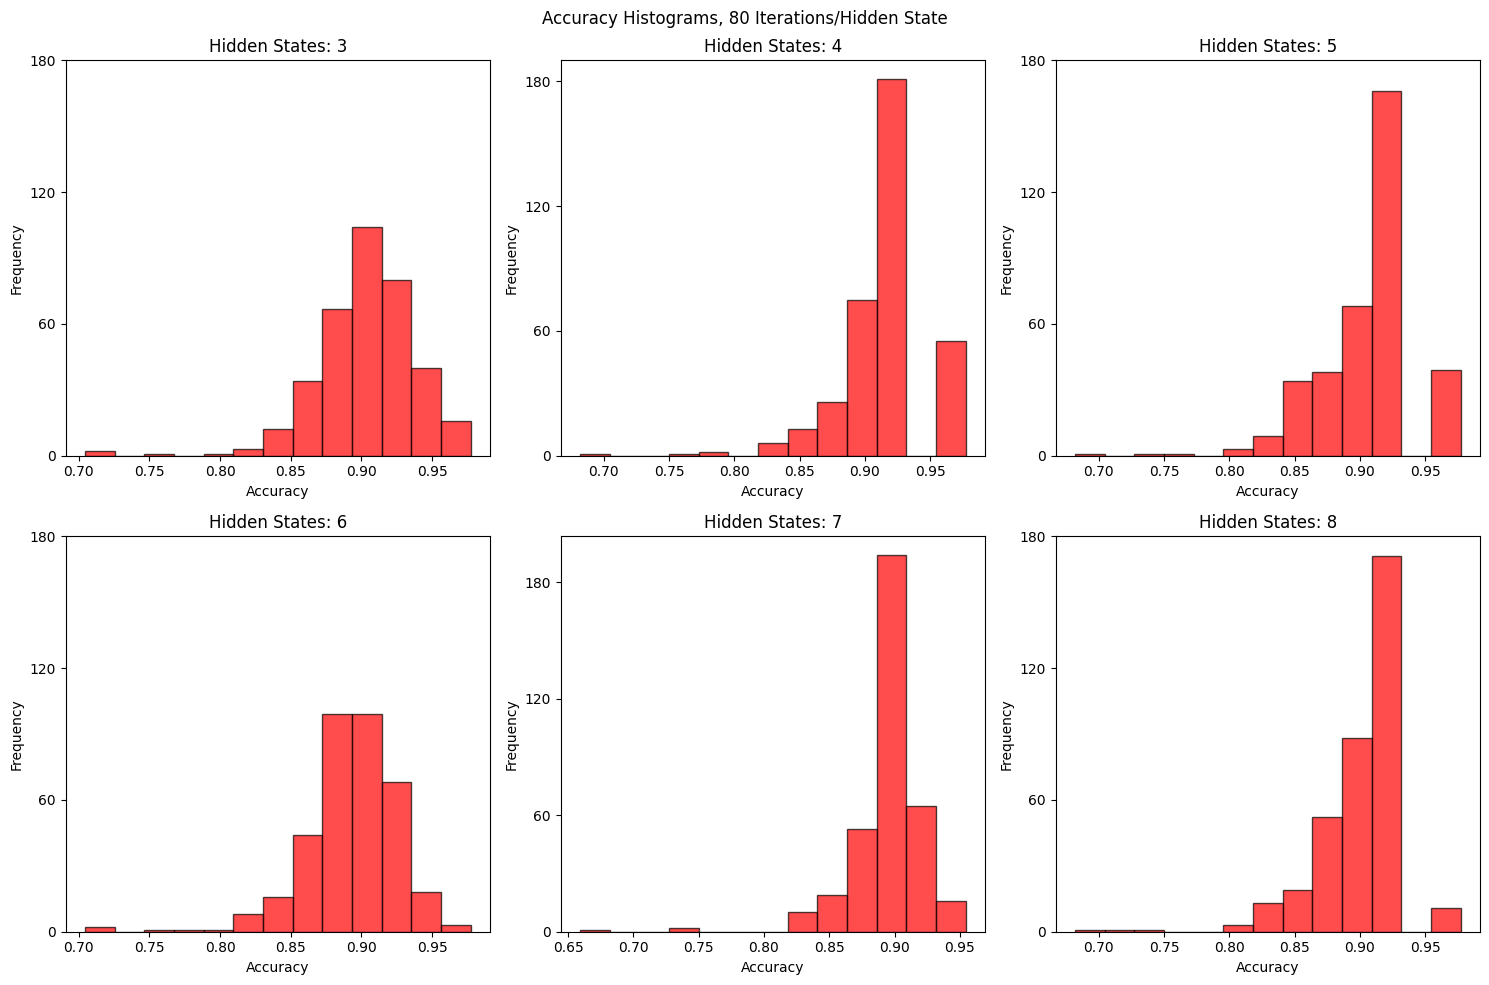

In [134]:
#generate histograms for the testing accuracy for different numbers of hidden states
n_bins = 13
max_frequency = 0
num_columns = 3

#calculate the number of rows based on the number of hidden states
num_hidden_states = len(cv_accuracies_test)
num_rows = (len(hidden_states_set) + num_columns - 1) // num_columns

#create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
fig.suptitle('Accuracy Histograms, 80 Iterations/Hidden State')
axes = axes.flatten()

#iterate over hidden states and create histograms
for i, (hidden_state, accuracies) in enumerate(cv_accuracies_test.items()):
    ax = axes[i]

    #create the histogram
    n, bins, patches = ax.hist(accuracies, bins=n_bins, edgecolor='black', alpha=0.7, color='red')
    max_frequency = max(max_frequency, max(n))
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Hidden States: {hidden_state}')

tolerance = 1
for ax in axes:
    ax.set_yticks(ticks=np.arange(0, max_frequency + tolerance, 60))

plt.tight_layout()
plt.show()

In [135]:
#print the average accuracy each number of hidden states and the standard deviations
formatted_accuracies = [f'{accuracy:.3f}' for accuracy in average_accuracies_test]
formatted_string = ', '.join(formatted_accuracies)
formatted_std = [f'{std:.3f}' for std in std_accuracies_test]
formatted_string_std = ', '.join(formatted_std)

print(f'Mean: {formatted_string}')
print(f'Standard Deviations: {formatted_string_std}')

Mean: 0.909, 0.908, 0.899, 0.897, 0.895, 0.893
Standard Deviations: 0.038, 0.038, 0.041, 0.036, 0.035, 0.036


The results of the cross-validation experiment indicates the median accuracies are consistently above $85\%$ for all the hidden states studied. However, it is important to note that the spread of the data is realtively large; the standard deviation is consistently between $0.035-0.041$ for all the hidden states studied. Furthermore, there are some trials with accuracies around $65%$. The 'best' case scenario is obtained for three and six hidden states where the minimum accuracy achieved is $70%$. Observing the histograms, we note that accuracies tend to be skewed to the right (i.e. towards higher accuracies) however we would caution making any conclusions due to the small size of the dataset.

### Discussion and Conclusion
We have shown that it is possible to use HMMs to classify objects based on vibration data from exploratory manipulations. Even in the worst case scenario (accuracies around $65\%$ from the cross-validation experiment), the accuracy of the classifier is better than random chance ($1/7 = 14.3\%$) and close to the accuracy achieved using a regression-based approach ($68.2\%$) [(Toprak, 2017)](#dataset). We hypothesis that the structure of the HMM captures underlying state transitions in the frequency-domain representation of vibration data. We first showed this qualitatively by identifying that variations in the MFCC components for each object appear to exist. We also showed that for some numbers of hidden-states the transition probability matrices have non-zero, off-diagonal elements.

To 'optimize' our HMM models, we modified different parameters and assessed the change in accuracy. We first showed that the accuracy of the model appears to increase as the number of hidden states increases. Counter intuitively, the cross-validation experiment demonstrated that the average performance of the model was fairly consistent across all the hidden states ($\texttt{hidden\_states} \in \{3,4,5,6,7,8\}$). It is possible that a small number of hidden states is required to capture the transition dynamics of the classification problem and that additional hidden states are redundant. A larger dataset is required to test this hypothesis. It is also possible that different train/test splits-with different allocations of real and ideal observations-perform best with different numbers of hidden states, explaining why all number of hidden states have similar performance. We then performed an experiment to assess which covariance matrix structure offered the highest accuracy. We selected $\texttt{cov\_type} = \texttt{"tied"}$ since it offered consistent performance across all the hidden states. We also conducted a parameter search across different MFCC features and window size and identified a set of parameters that offered consistently high performance across all the hidden states studied. 

In another experiment, we showed that the model is sensitive to the starting seed used to initialize parameters. We showed this by computing the standard deviation across all the accuracies obtained for different starting seeds. The sensitivity of HMM training to the starting seed can be addressed by manually initializing the starting transition probability matrix ($\mathbf{A}$) and the emission densities ($\mathbf{b}$). We also showed that by accounting for textural uniqueness, we are able to increase the accuracy of the model. The motivation for accounting for textural uniqueness is that a purely acoustic classifier should not be able to correctly classify objects with the same texture but different visual characteristics.

Although the results are promising, it is important to note that the dataset used for training and testing was small (only 13 observation per object, 144 total observations). To account for the limited availability of data, a cross-validation experiment was conducted. The results indicate the median accuracies are above $85\%$ for all the hidden states studied with standard deviations consistently around $4\%$ and accuracies from multiple trials around $65\%$. Although histograms plotting the frequency of accuracies achieved for different train/test splits appear to be skewed towards higher accuracies ($>85\%$)-rather than simply being uniformly distributed-we caution drawing any conclusions due to the small size of the dataset. Future studies should involve a larger dataset and a wider parameter search. A larger dataset would likely reveal which number of hidden states captures the transition dynamics of the problem.

Altogether, HMMs appear to offer classification accuracies similar to those obtained using regression models. An advantage of HMMs is that training times are short ($O(1-10~\text{seconds})$ for all objects with this dataset) which allows large parameter searches and cross-validation experiments to be conducted. For example, we ran $6~\texttt{hidden\_states}\cdot \frac{360~\text{iterations}}{\texttt{hidden\_state}} = 2160~\text{iterations}$ in under six hours for an exhaustive cross-validation experiment (i.e. all combinations were tested).

#### References
<a id=dataset></a>
S. Toprak, N. Navarro-Guerrero, and S. Wermter, “Evaluating Integration Strategies for Visuo-Haptic Object Recognition,” Cognitive Computation, vol. 10, no. 3, pp. 408–425, Dec. 2017, doi: https://doi.org/10.1007/s12559-017-9536-7.